In [1]:
#############################################################
#
# NBA Individual Player Performance Prediction
#
#############################################################
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from mrsc.src.from_tslib.svdWrapper import SVDWrapper as SVD
from mrsc.src.from_tslib.tsSVDModel import SVDModel
from mrsc.src.from_tslib import tsUtils

from statsmodels.tsa.arima_model import ARMA

# for entropy
import zlib
import binascii
import re
import math

import pylab 
import scipy.stats as stats
from scipy.stats import entropy
from scipy.stats import bernoulli
from math import log, e
import timeit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

plt.rcParams.update({'font.size': 14})

In [85]:
"""
import data
"""
print("*** importing data ***")

annual_pred = pd.read_pickle("annual_pred_2016.pkl")
target_players = list(annual_pred.columns)

data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

game_metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
colname_dict = {'playPTS': 'PTS_G', 'playAST': 'AST_G', 'playTO':'TOV_G',
                'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P_G',
                'playTRB':'TRB_G','playSTL':'STL_G','playBLK':'BLK_G'}

# edit column names to fit with the yearly data
data = data.rename(columns=colname_dict)

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

stats_game = data[["date","gmDate","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

df = pd.read_pickle("../data/nba-hosoi/nba_scores_2103-2018.pkl")
df = df[["nbaId","path","game_date","home","away","season"]].drop_duplicates().reset_index(drop=True)

a = pd.concat([df,(df["game_date"] + str(" ") + df["home"]).rename("key")], axis=1)
b = pd.concat([df,(df["game_date"] + str(" ") + df["away"]).rename("key")], axis=1)
appended = pd.concat([a,b], axis=0)

new_data = pd.concat([data, (data["gmDate"] + str(" ") + data["teamAbbr"]).rename("key")], axis=1)
data_fin = new_data.merge(appended, how='left', left_on='key', right_on='key')

stats_game = data_fin[["date","gmDate","gmTime","nbaId","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

player_list_1 = ['Stephen Curry', 'Kevin Durant', 'LeBron James', 'Russell Westbrook', 'James Harden', 'Paul George', 'Kyrie Irving', 'Chris Paul']
player_list_2 = ['Al Horford','Trevor Ariza','Eric Gordon']

*** importing data ***


In [134]:
def compress(uncompressed):
    """Compress a string to a list of output symbols."""
 
    # Build the dictionary.
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
    
    w = ""
    result = []
    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    return result

def decompress(compressed):
    """Decompress a list of output ks to a string."""
 
    dict_size = 256
    dictionary = dict((i, chr(i)) for i in range(dict_size))
 
    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    result = StringIO()
    w = chr(compressed.pop(0))
    result.write(w)
    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result.write(entry)
 
        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
 
        w = entry
    return result.getvalue()

def entropy(prob):
    ent = 0.
    for p in prob:
        ent = ent - p*log(p,2)
    return ent

def list_to_string(a):
    return re.sub('\W+','', str(a) )

def lzw_test(delta):
    delta_string = list_to_string(delta)
    delta_compressed = compress(delta_string)
    delta_decompressed = decompress(delta_compressed)
    ratio = len(delta_compressed)/len(delta_string)
    error = np.sum(np.array([int(i) for i in delta_string]) != np.array([int(i) for i in delta_decompressed]))
    
    print("- using lzw")
    print("original size   : ", len(delta))
    print("compressed size : ", len(delta_compressed))
    print("ratio           : ", ratio)
    print("error           : ", error/len(delta_string))


In [ ]:

def random_generator(size, p=0.5, space=50):
    numrand = np.random.binomial(1,p, size=size*space)
    spaced = numrand[0::space]
    a = list(spaced.astype(int))
    random_str = list_to_string(a)
    return random_str

def get_delta(x):
    delta = np.zeros(len(x)-1)
    delta[(x - x.shift(+1))[1:]>0] = 1
    # 1 = increase
    # 0 = not increase (decrease or stays the same)
    delta = delta.astype(int)
    return list(delta)

def regression_model(size, number_of_p=30, verbose=False):
    ratio_list =[]
    true_entropy = []
    for p in np.linspace(1e-5,0.5,number_of_p):
        true_entropy.append(entropy([p,1-p]))
        uncompressed = random_generator(size, p)
        compressed = compress(uncompressed)
        compression_ratio = len(compressed)/len(uncompressed)
        ratio_list.append(compression_ratio)
        
        if verbose:
            print("p : ", p)
            print("theoretical entropy: ", entropy([p,1-p]))
            print("compression ratio: ", compression_ratio)
            print()

    # linear regression
    reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(ratio_list[:]))
    print("y = ax + b model")
    print("a = ", reg.coef_)
    print("b = ", reg.intercept_)

    plt.plot(true_entropy, ratio_list, marker='.', label = "LZW compressor")
    plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression")

    plt.title("Compression Ratio of size {} Bernoulli(p), 0<p<0.5".format(size))
    plt.xlabel("theoretical entropy")
    plt.ylabel("compression ratio")
    plt.legend()
    plt.show()

    return ratio_list, true_entropy

# Lower Bound - Binary

In [194]:
def get_entropy(size, compression_ratio):
    # mapping compression ratio to entropy
    ratio_list, true_entropy = regression_model(size, number_of_p=30, verbose=False)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))
    return reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))

def f(p):
    return -p*log(p,2) - (1-p)*log(1-p,2)

def df(p):
    return -log(p/(1-p),2) 

def inverse_binary_entropy(H, a=0.001):
    # from entropy value, get p s.t. 0 < p < 0.5
    # a = accuracy
    p_hat = 0.25
    err = np.abs(f(p_hat) - H)
    while(err > a):
        err = np.abs(f(p_hat) - H)
        p_hat = p_hat - 0.01* (f(p_hat) - H) * df(p_hat)
        if (p_hat<0):
            p_hat = 0
        if (p_hat>0.5):
            p_hat = 0.5
    
    return p_hat

In [96]:
players = ['LeBron James', 'Kevin Durant', 'Stephen Curry', 'Russell Westbrook', 'James Harden', 
          'Giannis Antetokounmpo', 'Anthony Davis', 'Jimmy Butler', 'Draymond Green', 'Chris Paul',
          'Klay Thompson', 'John Wall', 'Paul George', 'DeMarcus Cousins', 'Rudy Gobert', 'Kyle Lowry',
          'Paul Millsap', 'Blake Griffin', 'Damian Lillard', 'DeAndre Jordan', 'Kyrie Irving',
          'Al Horford', 'DeMar DeRozan', 'Kevin Love', 'Andre Drummond', 'Carmelo Anthony', 'LaMarcus Aldridge',
          'Kemba Walker', 'Eric Bledsoe', 'Dwight Howard', 'Eric Gordon', 'George Hill', 'Jeff Teague', 
          'Andrew Wiggins', 'Serge Ibaka', 'Avery Bradley', 'Trevor Ariza', 'Devin Booker', 'Bradley Beal',
          'Karl-Anthony Towns', 'Marc Gasol', 'Khris Middleton']

LeBron James
p =  0.4746136865342163
length =  453
y = ax + b model
a =  [0.16275589]
b =  0.07496990209364664


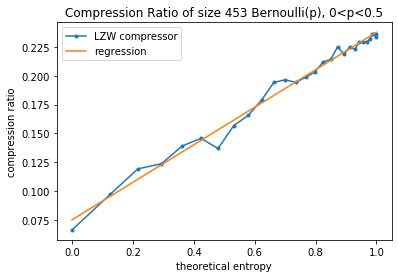

compression ratio:  0.22958057395143489
estimated entropy:  0.9470153329619303
P(e) lower bound :  0.3652014000323431
--------------------------

Kevin Durant
p =  0.4846153846153846
length =  390
y = ax + b model
a =  [0.16712752]
b =  0.0783611795421651


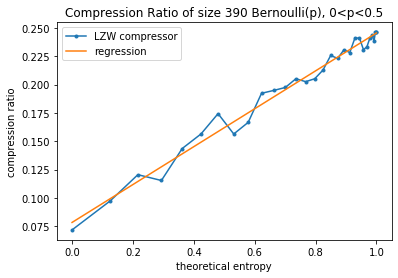

compression ratio:  0.23076923076923078
estimated entropy:  0.9084143396959264
P(e) lower bound :  0.3236592317711322
--------------------------

Stephen Curry
p =  0.5022522522522522
length =  444
y = ax + b model
a =  [0.16762469]
b =  0.07146567639321875


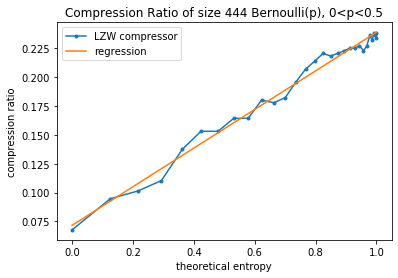

compression ratio:  0.22297297297297297
estimated entropy:  0.9013916665379885
P(e) lower bound :  0.31718510528250443
--------------------------

Russell Westbrook
p =  0.49195402298850577
length =  435
y = ax + b model
a =  [0.16948027]
b =  0.07148944448445546


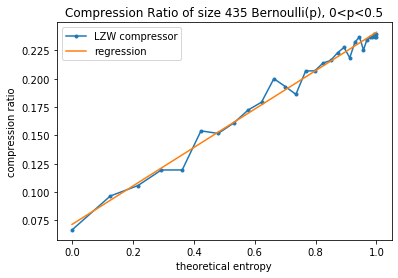

compression ratio:  0.22528735632183908
estimated entropy:  0.9047344649068246
P(e) lower bound :  0.3202339573070502
--------------------------

James Harden
p =  0.47854077253218885
length =  466
y = ax + b model
a =  [0.16237803]
b =  0.07420033779072571


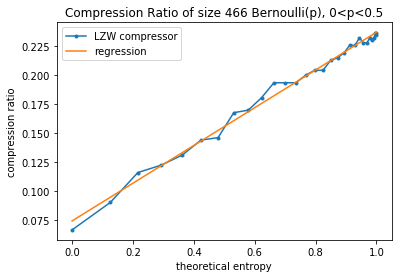

compression ratio:  0.22103004291845493
estimated entropy:  0.9027542827755929
P(e) lower bound :  0.31842087908341365
--------------------------

Giannis Antetokounmpo
p =  0.47959183673469385
length =  392
y = ax + b model
a =  [0.17083436]
b =  0.07368774189951094


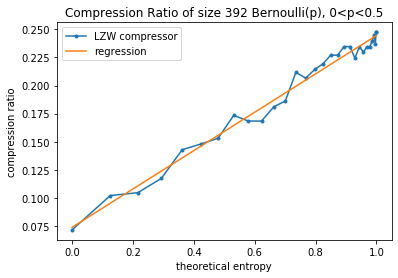

compression ratio:  0.23469387755102042
estimated entropy:  0.9388188249796928
P(e) lower bound :  0.35530876018019075
--------------------------

Anthony Davis
p =  0.4767726161369193
length =  409
y = ax + b model
a =  [0.16996189]
b =  0.07376054275230771


compression ratio:  0.23227383863080683
estimated entropy:  0.9290439868808672
P(e) lower bound :  0.3443764119333975
--------------------------

Jimmy Butler
p =  0.49038461538461536
length =  416
y = ax + b model
a =  [0.16966491]
b =  0.07165224876711748


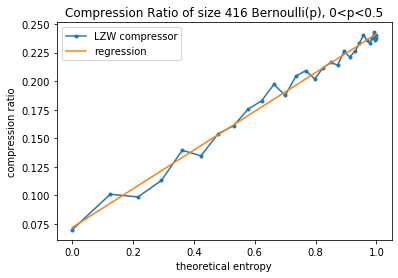

compression ratio:  0.23076923076923078
estimated entropy:  0.9349124317971086
P(e) lower bound :  0.3508374051093483
--------------------------

Draymond Green
p =  0.4678111587982833
length =  466
y = ax + b model
a =  [0.16419109]
b =  0.07240599656003223


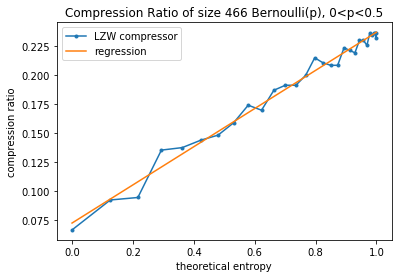

compression ratio:  0.2167381974248927
estimated entropy:  0.8767515608132058
P(e) lower bound :  0.2962466724408255
--------------------------

Chris Paul
p =  0.47044334975369456
length =  406
y = ax + b model
a =  [0.17329982]
b =  0.07068537519455062


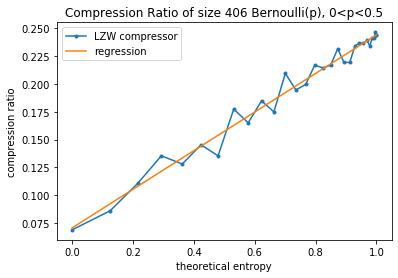

compression ratio:  0.2315270935960591
estimated entropy:  0.9232697737166945
P(e) lower bound :  0.33828857517115657
--------------------------

Klay Thompson
p =  0.48723404255319147
length =  470
y = ax + b model
a =  [0.17224983]
b =  0.06561021254628491


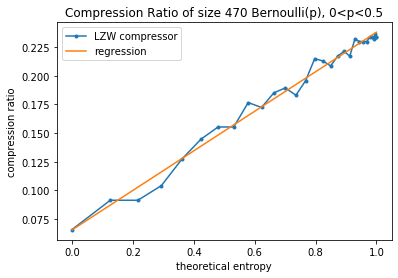

compression ratio:  0.21914893617021278
estimated entropy:  0.889044801305325
P(e) lower bound :  0.30637691910025644
--------------------------

John Wall
p =  0.49135802469135803
length =  405
y = ax + b model
a =  [0.16607643]
b =  0.07854133370819916


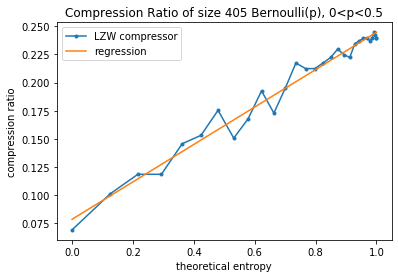

compression ratio:  0.2271604938271605
estimated entropy:  0.8903051992899839
P(e) lower bound :  0.30744966512087907
--------------------------

Paul George
p =  0.47619047619047616
length =  399
y = ax + b model
a =  [0.1672006]
b =  0.0771098845089087


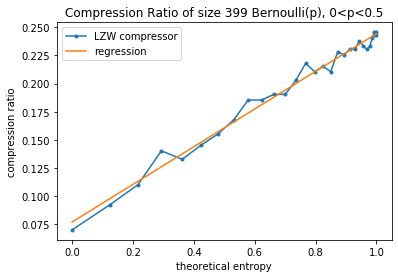

compression ratio:  0.23558897243107768
estimated entropy:  0.9446441370055078
P(e) lower bound :  0.3622626578584621
--------------------------

DeMarcus Cousins
p =  0.5038560411311054
length =  389
y = ax + b model
a =  [0.17233236]
b =  0.07678361899294739


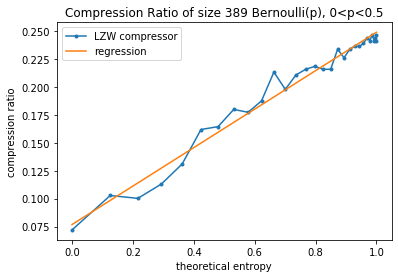

compression ratio:  0.2262210796915167
estimated entropy:  0.8635837503622518
P(e) lower bound :  0.28599090053770065
--------------------------

Rudy Gobert
p =  0.4691358024691358
length =  324
y = ax + b model
a =  [0.17511466]
b =  0.08091970874505645


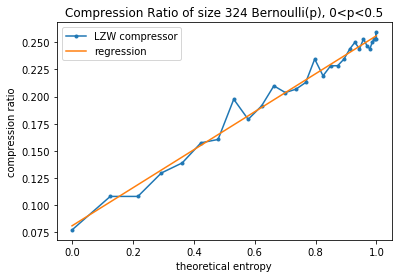

compression ratio:  0.24691358024691357
estimated entropy:  0.9434716264834505
P(e) lower bound :  0.36083304907109437
--------------------------

Kyle Lowry
p =  0.4895591647331787
length =  431
y = ax + b model
a =  [0.1662442]
b =  0.07457871911974301


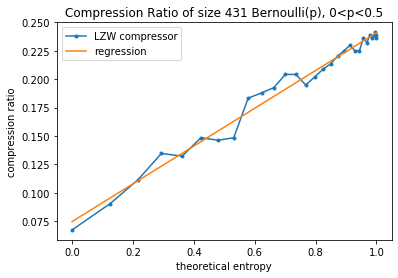

compression ratio:  0.23201856148491878
estimated entropy:  0.9427586474630111
P(e) lower bound :  0.359971772612738
--------------------------

Paul Millsap
p =  0.46601941747572817
length =  412
y = ax + b model
a =  [0.16584438]
b =  0.07616824762236411


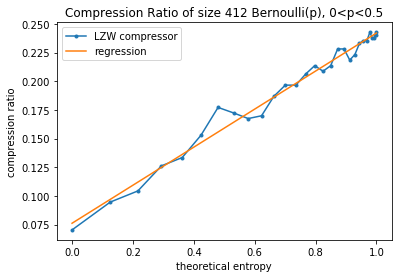

compression ratio:  0.23058252427184467
estimated entropy:  0.9275382774359379
P(e) lower bound :  0.3427647747024213
--------------------------

Blake Griffin
p =  0.49473684210526314
length =  380
y = ax + b model
a =  [0.1688695]
b =  0.07784477445748123


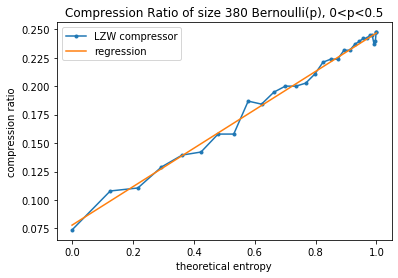

compression ratio:  0.23421052631578948
estimated entropy:  0.9240491928257196
P(e) lower bound :  0.33909530809583155
--------------------------

Damian Lillard
p =  0.4594017094017094
length =  468
y = ax + b model
a =  [0.1699798]
b =  0.0662548500205156


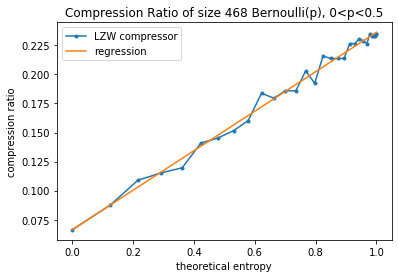

compression ratio:  0.22435897435897437
estimated entropy:  0.9281191096111597
P(e) lower bound :  0.3433840494648586
--------------------------

DeAndre Jordan
p =  0.4895833333333333
length =  480
y = ax + b model
a =  [0.16713904]
b =  0.06748223699979472


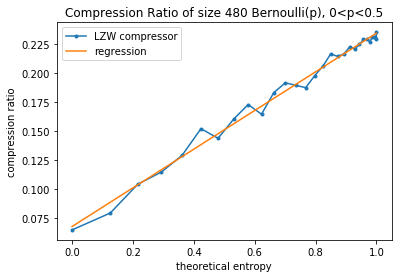

compression ratio:  0.22083333333333333
estimated entropy:  0.9153468161904316
P(e) lower bound :  0.3303155879743422
--------------------------

Kyrie Irving
p =  0.46786632390745503
length =  389
y = ax + b model
a =  [0.16957067]
b =  0.07721166817368189


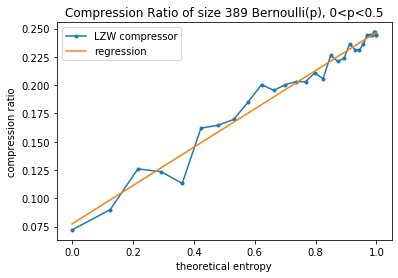

compression ratio:  0.2390745501285347
estimated entropy:  0.948174125231548
P(e) lower bound :  0.3666629972793375
--------------------------

Al Horford
p =  0.4925
length =  400
y = ax + b model
a =  [0.17710218]
b =  0.06905407947968464


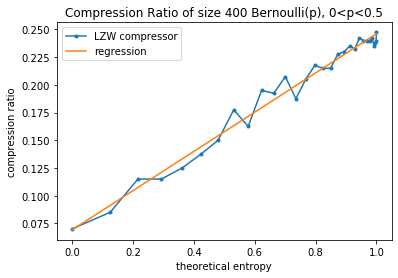

compression ratio:  0.2325
estimated entropy:  0.9187499016347086
P(e) lower bound :  0.3336892084722295
--------------------------

DeMar DeRozan
p =  0.4646017699115044
length =  452
y = ax + b model
a =  [0.16050406]
b =  0.07508196148965929


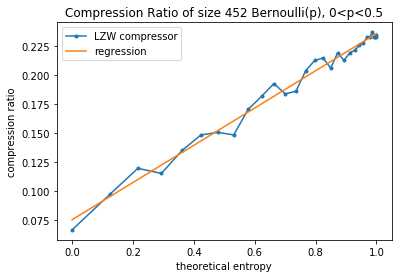

compression ratio:  0.2234513274336283
estimated entropy:  0.9212602058095812
P(e) lower bound :  0.3362263680292908
--------------------------

Kevin Love
p =  0.4876712328767123
length =  365
y = ax + b model
a =  [0.17155015]
b =  0.07759879021596171


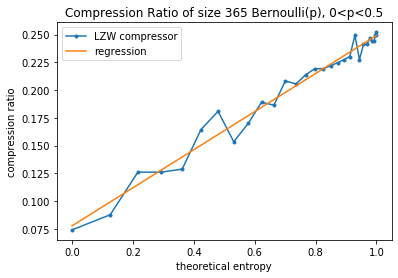

compression ratio:  0.2356164383561644
estimated entropy:  0.9157496798527621
P(e) lower bound :  0.3307112954013783
--------------------------

Andre Drummond
p =  0.4653679653679654
length =  462
y = ax + b model
a =  [0.16814313]
b =  0.06964009221457519


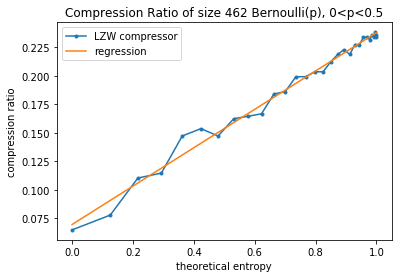

compression ratio:  0.22294372294372294
estimated entropy:  0.9091756908238181
P(e) lower bound :  0.32437603592281583
--------------------------

Carmelo Anthony
p =  0.48157248157248156
length =  407
y = ax + b model
a =  [0.16697223]
b =  0.07627873838710188


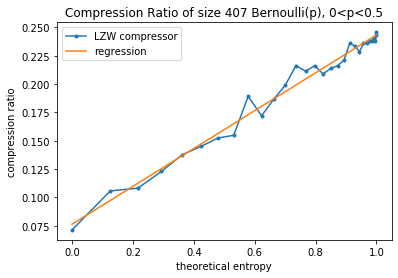

compression ratio:  0.23095823095823095
estimated entropy:  0.9226080890404252
P(e) lower bound :  0.3376061372103783
--------------------------

LaMarcus Aldridge
p =  0.4838709677419355
length =  434
y = ax + b model
a =  [0.16621178]
b =  0.07196072127653268


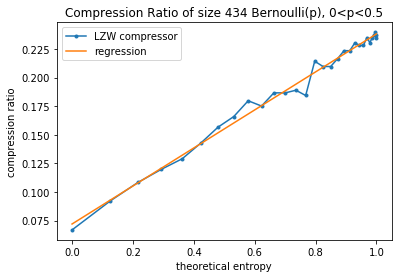

compression ratio:  0.22580645161290322
estimated entropy:  0.9234421296613141
P(e) lower bound :  0.3384662940665357
--------------------------

Kemba Walker
p =  0.48464912280701755
length =  456
y = ax + b model
a =  [0.17050554]
b =  0.0662827202205652


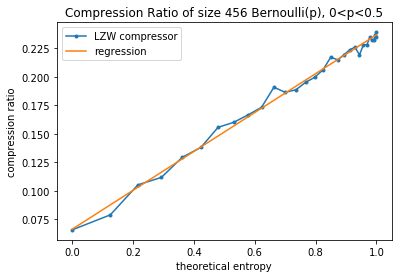

compression ratio:  0.22149122807017543
estimated entropy:  0.9089822996256814
P(e) lower bound :  0.32419368059655196
--------------------------

Eric Bledsoe
p =  0.4783783783783784
length =  370
y = ax + b model
a =  [0.16695146]
b =  0.08331239431532161


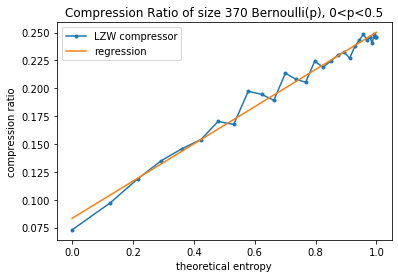

compression ratio:  0.23783783783783785
estimated entropy:  0.9221339468951945
P(e) lower bound :  0.33711925255351827
--------------------------

Dwight Howard
p =  0.4648910411622276
length =  413
y = ax + b model
a =  [0.16971672]
b =  0.07487143237397546


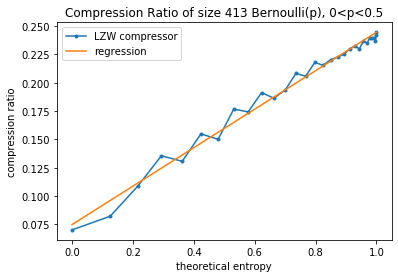

compression ratio:  0.23002421307506055
estimated entropy:  0.9114014017011826
P(e) lower bound :  0.3264931559671361
--------------------------

Eric Gordon
p =  0.4887640449438202
length =  356
y = ax + b model
a =  [0.16886975]
b =  0.08222661653677964


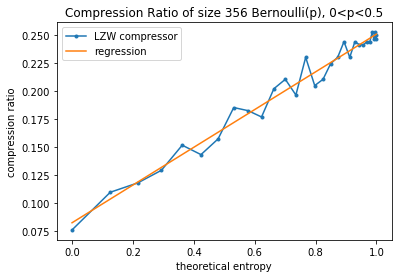

compression ratio:  0.2303370786516854
estimated entropy:  0.8731340032152811
P(e) lower bound :  0.29337124849507173
--------------------------

George Hill
p =  0.4817708333333333
length =  384
y = ax + b model
a =  [0.17077907]
b =  0.07710729265117844


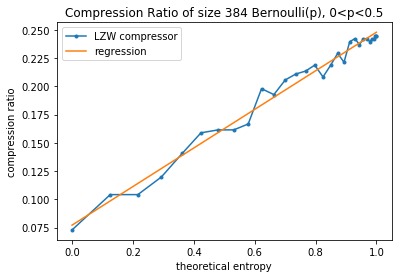

compression ratio:  0.23177083333333334
estimated entropy:  0.9024462646505608
P(e) lower bound :  0.3181402864385723
--------------------------

Jeff Teague
p =  0.48484848484848486
length =  462
y = ax + b model
a =  [0.16444869]
b =  0.07292543547654767


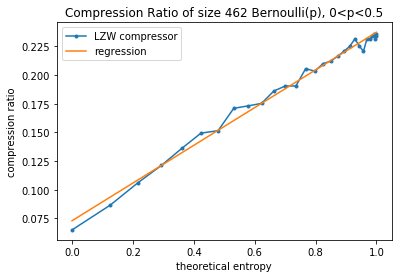

compression ratio:  0.22294372294372294
estimated entropy:  0.9104837453822193
P(e) lower bound :  0.3256171478931201
--------------------------

Andrew Wiggins
p =  0.46319018404907975
length =  326
y = ax + b model
a =  [0.18528364]
b =  0.07403715464714603


compression ratio:  0.24233128834355827
estimated entropy:  0.9022549101455003
P(e) lower bound :  0.31796646792545036
--------------------------

Serge Ibaka
p =  0.48358862144420134
length =  457
y = ax + b model
a =  [0.16980703]
b =  0.06790159439274238


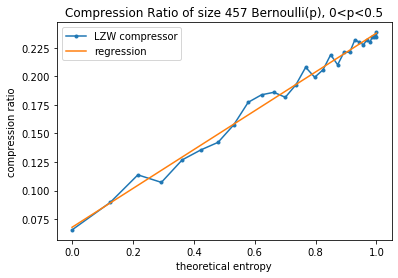

compression ratio:  0.22538293216630198
estimated entropy:  0.9248590348255837
P(e) lower bound :  0.33993878357668783
--------------------------

Avery Bradley
p =  0.46831955922865015
length =  363
y = ax + b model
a =  [0.17349008]
b =  0.07676561753612399


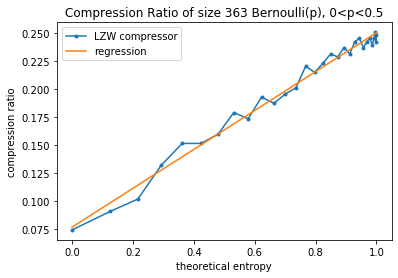

compression ratio:  0.2369146005509642
estimated entropy:  0.9201552751094267
P(e) lower bound :  0.3351043615255855
--------------------------

Trevor Ariza
p =  0.4841628959276018
length =  442
y = ax + b model
a =  [0.17214205]
b =  0.06842835598993403


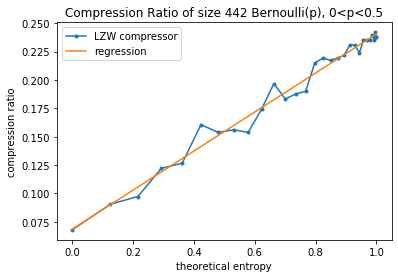

compression ratio:  0.22850678733031674
estimated entropy:  0.9257974611102034
P(e) lower bound :  0.3409228783276265
--------------------------

Devin Booker
p =  0.4782608695652174
length =  207
y = ax + b model
a =  [0.18134002]
b =  0.10330292322226126


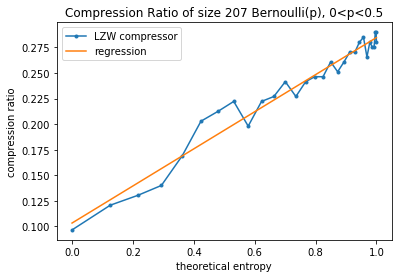

compression ratio:  0.2753623188405797
estimated entropy:  0.9402106916039236
P(e) lower bound :  0.35693773426653386
--------------------------

Bradley Beal
p =  0.4765432098765432
length =  405
y = ax + b model
a =  [0.17574347]
b =  0.06843401284704403


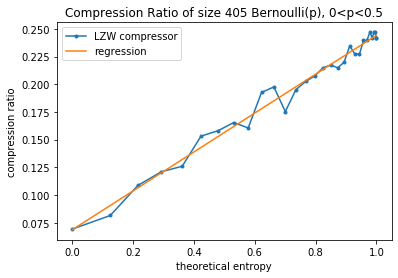

compression ratio:  0.2271604938271605
estimated entropy:  0.8999662202952065
P(e) lower bound :  0.31590118825772484
--------------------------

Karl-Anthony Towns
p =  0.49387755102040815
length =  245
y = ax + b model
a =  [0.17468981]
b =  0.10039265711765302


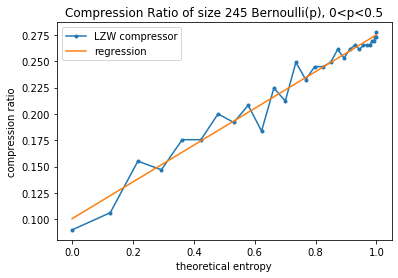

compression ratio:  0.2571428571428571
estimated entropy:  0.8910986872233125
P(e) lower bound :  0.3081274821407591
--------------------------

Marc Gasol
p =  0.4784688995215311
length =  418
y = ax + b model
a =  [0.16761589]
b =  0.07402630791457036


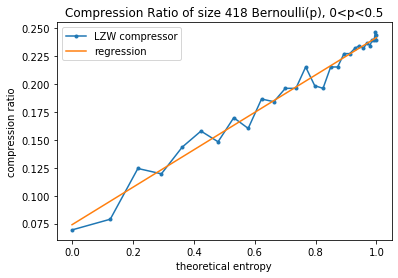

compression ratio:  0.22248803827751196
estimated entropy:  0.8816928017851134
P(e) lower bound :  0.30024855467326517
--------------------------

Khris Middleton
p =  0.4960212201591512
length =  377
y = ax + b model
a =  [0.17619673]
b =  0.07180776808940825


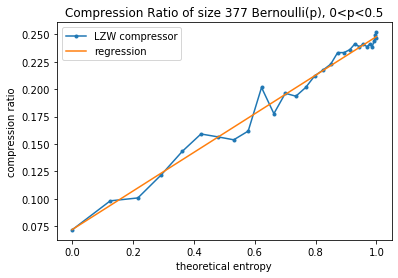

compression ratio:  0.2413793103448276
estimated entropy:  0.9577345392185409
P(e) lower bound :  0.3794252031173192
--------------------------



In [195]:
metric = "PTS_G"
start_date = "2012-10-01"
interv_date = "2017-10-01"
end_date = "2018-10-01"
quality = 9 # best but slow
span = 3
#############
lbs=[]
for player_name in players:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_delta = get_delta(player_data)
    player_delta_string = list_to_string(player_delta)
    p = np.sum(np.array(player_delta) == 1)/len(player_delta)
    size = len(player_delta)
    print("p = ", p)
    print("length = ", size)
    
    compressed = compress(player_delta_string)
    compression_ratio = len(compressed)/len(player_delta_string)    
    ent = get_entropy(size, compression_ratio)
    lb = inverse_binary_entropy(ent[0], a=0.0001)
    lbs.append(lb)
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("P(e) lower bound : ", lb)
    print("--------------------------")
    print()

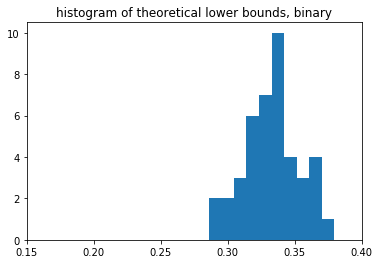

In [261]:
plt.title("histogram of theoretical lower bounds, binary")
plt.hist(lbs)
plt.xlim(0.15,0.40)
plt.show()

In [262]:
np.mean(lbs)

0.33227259154730565

# Lower Bound - Ternary

In [495]:
def multinomial(n,p = [1/3,1/3,1/3]):
    final = []
    for i in range(n):
        result = np.random.multinomial(1, p)
        final.append(np.array(range(len(p)))[result == 1][0])
    return list(np.array(final).T)

def regression_model_ternary(size, number_of_p=30, verbose=False, show_graph=True):
    ratio_list =[]
    true_entropy = []
    
    probabilities=[]
    for i in range(number_of_p):
        p1= np.random.uniform(0,1,1)[0]
        p2 = np.random.uniform(0,1,1)[0]
        p3 = np.random.uniform(0,1,1)[0]
        
        probabilities.append([p1,p2,p3]/(p1+p2+p3))
            
    for p in probabilities:
        true_entropy.append(entropy(p))
        uncompressed = list_to_string(multinomial(size, p))
        compressed = compress(uncompressed)
        compression_ratio = len(compressed)/len(uncompressed)
        ratio_list.append(compression_ratio)
        
        if verbose:
            print("p : ", p)
            print("theoretical entropy: ", entropy(p))
            print("compression ratio: ", compression_ratio)
            print()
    
    # linear regression
    reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(ratio_list[:]))
    
    if show_graph:
        print("y = ax + b model")
        print("a = ", reg.coef_)
        print("b = ", reg.intercept_)

        plt.scatter(true_entropy, ratio_list, marker='.', label = "LZW compressor")
        plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression", color="orange")

        plt.title("Compression Ratio for Multinomial(3,p) with Size {}".format(size))
        plt.xlabel("theoretical entropy")
        plt.ylabel("compression ratio")
        plt.legend()
        plt.show()

    return ratio_list, true_entropy

In [392]:
plt.plot(mean_thus_far(player_data)+std_thus_far(player_data))
plt.plot(player_data)
plt.plot(mean_thus_far(player_data)-std_thus_far(player_data))
plt.show()

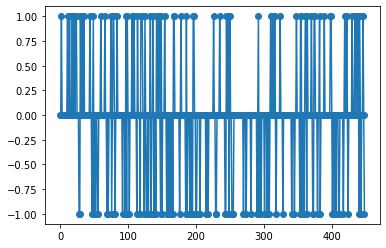

In [400]:
plt.plot(get_gamma(x, x, 1, 5, method="thus_far"), marker='o')

In [463]:
def mean_thus_far(x):
    mean=[]
    for i in range(1, len(x)+1):
        mean.append(x[:i].mean())
    return np.array(mean)

def std_thus_far(x):
    std=[]
    for i in range(1, len(x)+1):
        std.append(x[:i].std())
    return np.array(std)

def get_gamma(y, x, alpha, window):
    # y : refence to calculate the mean/std
    # x : evaluate this based on men/std(y)
    # window = rolling window size
    # alpha = +- alpha * std
    
    roll_mean = y.rolling(window).mean()[window:]
    roll_std = y.rolling(window).std()[window:]
    thus_mean = mean_thus_far(y)[:window]
    thus_std = std_thus_far(y)[:window]
    thus_std[0]=0

    # upper boundary (0, 1)
    pre = thus_mean + thus_std * alpha
    post = np.array(roll_mean + roll_std * alpha)
    upper = np.hstack((pre, post))

    # lower boundary (-1, 0)
    pre = thus_mean - thus_std * alpha
    post = np.array(roll_mean - roll_std * alpha)
    lower = np.hstack((pre, post))
 
    gamma = np.zeros(len(x))
    gamma[x > upper] = 1
    gamma[x < lower] = -1

    # 1 = above mean + alpha*std
    # -1 = below mean - alpha*std
    # 0 = between mean +- alpha*std
    gamma = gamma.astype(int)
    return list(gamma), upper, lower

def get_entropy_ternary(size, compression_ratio, show_graph=True):
    # mapping compression ratio to entropy
    ratio_list, true_entropy = regression_model_ternary(size, number_of_p=100, verbose=False, show_graph=show_graph)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))
    return reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))

In [406]:
def g(p):
    return entropy([p,1-p]) + p

def dg(p):
    return -log(p/(1-p),2) + 1

def inverse_binary_entropy_1(H, a=0.001):
    # from entropy value, get p s.t. 0 < p < 0.5
    # a = accuracy
    p_hat = 0.33
    err = np.abs(g(p_hat) - H)
    while(err > a):
        err = np.abs(g(p_hat) - H)
        p_hat = p_hat - 0.01* (g(p_hat) - H) * dg(p_hat)
        if (p_hat < 0):
            p_hat = 0
        if (p_hat > 2/3):
            p_hat = 2/3
    
    return p_hat

LeBron James


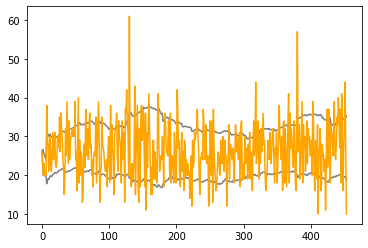

p =  [0.17180616740088106, 0.6607929515418502, 0.16740088105726872]
length =  454
y = ax + b model
a =  [0.15130531]
b =  0.08550278590352403


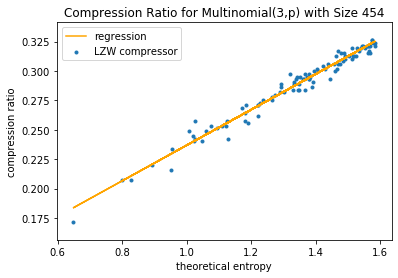

compression ratio:  0.27973568281938327
estimated entropy:  1.2850875558415944
P(e) lower bound :  0.35003164937988424
P(e) upper bound :  0.33920704845814975
--------------------------

Kevin Durant


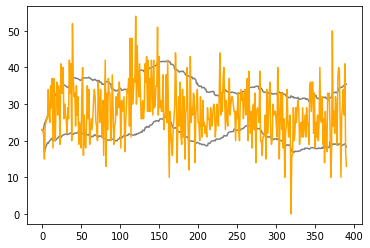

p =  [0.1585677749360614, 0.6854219948849105, 0.15601023017902813]
length =  391
y = ax + b model
a =  [0.15306826]
b =  0.0917563671704156


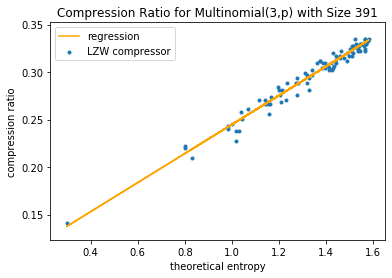

compression ratio:  0.27621483375959077
estimated entropy:  1.2090127615578594
P(e) lower bound :  0.3131504330886869
P(e) upper bound :  0.3145780051150895
--------------------------

Stephen Curry


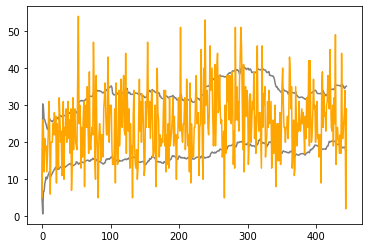

p =  [0.13707865168539327, 0.698876404494382, 0.16404494382022472]
length =  445
y = ax + b model
a =  [0.15089999]
b =  0.0869701282804258


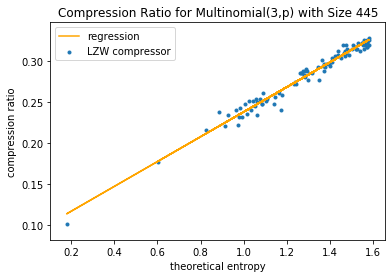

compression ratio:  0.2651685393258427
estimated entropy:  1.184169321125509
P(e) lower bound :  0.301716885226876
P(e) upper bound :  0.30112359550561796
--------------------------

Russell Westbrook


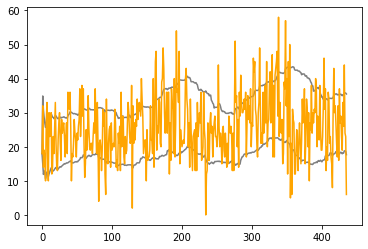

p =  [0.14908256880733944, 0.6720183486238532, 0.17889908256880735]
length =  436
y = ax + b model
a =  [0.14687166]
b =  0.09326026609157712


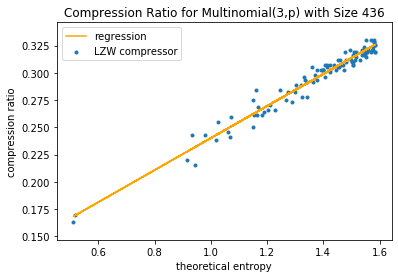

compression ratio:  0.27293577981651373
estimated entropy:  1.2287795149277245
P(e) lower bound :  0.3225643713914847
P(e) upper bound :  0.32798165137614677
--------------------------

James Harden


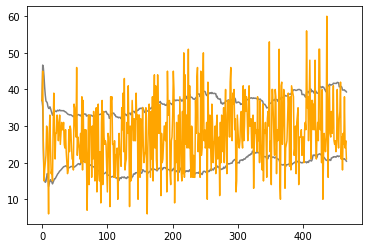

p =  [0.15417558886509636, 0.6916488222698073, 0.15417558886509636]
length =  467
y = ax + b model
a =  [0.14513364]
b =  0.09204720339559372


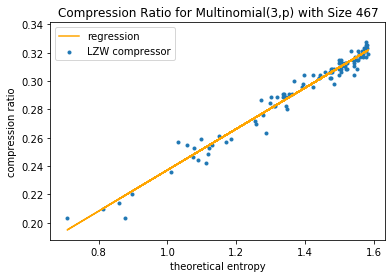

compression ratio:  0.26552462526766596
estimated entropy:  1.201029574974041
P(e) lower bound :  0.30944634821002787
P(e) upper bound :  0.3083511777301927
--------------------------

Giannis Antetokounmpo


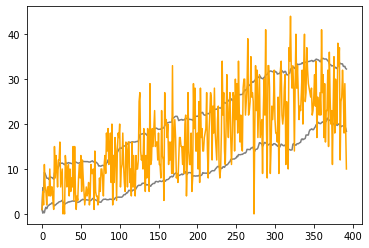

p =  [0.11959287531806616, 0.6437659033078881, 0.2366412213740458]
length =  393
y = ax + b model
a =  [0.15751064]
b =  0.08668841510975739


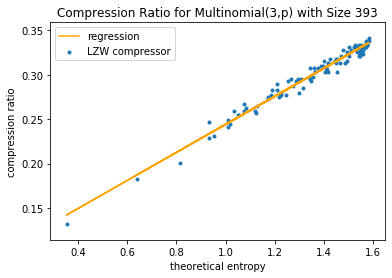

compression ratio:  0.2875318066157761
estimated entropy:  1.2768655982656008
P(e) lower bound :  0.3457231021862788
P(e) upper bound :  0.356234096692112
--------------------------

Anthony Davis


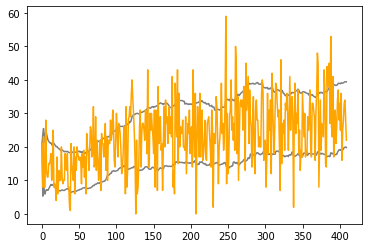

p =  [0.12439024390243902, 0.6853658536585366, 0.1902439024390244]
length =  410
y = ax + b model
a =  [0.15602706]
b =  0.0851001469832322


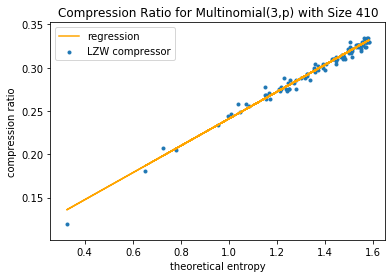

compression ratio:  0.2707317073170732
estimated entropy:  1.192505170159596
P(e) lower bound :  0.30550170106326147
P(e) upper bound :  0.3146341463414634
--------------------------

Jimmy Butler


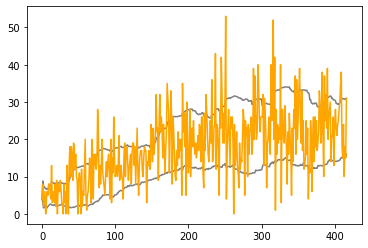

p =  [0.12470023980815348, 0.6738609112709832, 0.2014388489208633]
length =  417
y = ax + b model
a =  [0.15108536]
b =  0.09105278691771537


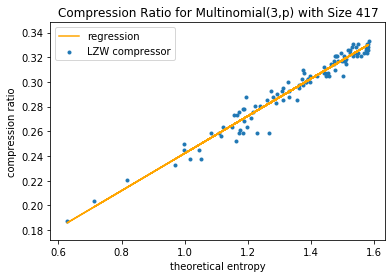

compression ratio:  0.2709832134292566
estimated entropy:  1.1972927239695164
P(e) lower bound :  0.30771977539120915
P(e) upper bound :  0.32613908872901676
--------------------------

Draymond Green


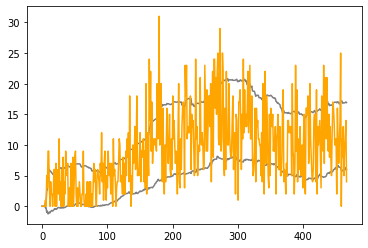

p =  [0.14132762312633834, 0.6488222698072805, 0.20985010706638116]
length =  467
y = ax + b model
a =  [0.15259246]
b =  0.08103578898814645


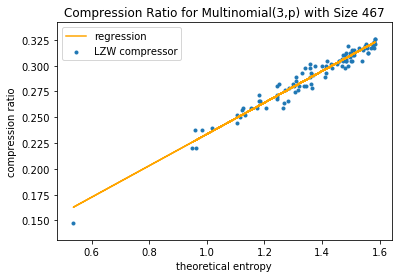

compression ratio:  0.28051391862955033
estimated entropy:  1.3099399564818908
P(e) lower bound :  0.363471266744535
P(e) upper bound :  0.3511777301927195
--------------------------

Chris Paul


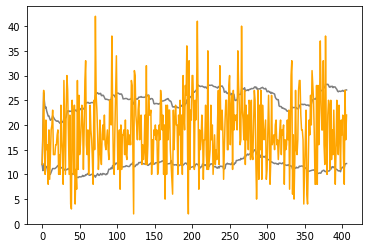

p =  [0.16953316953316952, 0.6855036855036855, 0.14496314496314497]
length =  407
y = ax + b model
a =  [0.14940839]
b =  0.09484848334640003


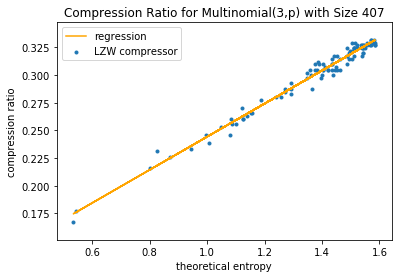

compression ratio:  0.27764127764127766
estimated entropy:  1.2264180928204869
P(e) lower bound :  0.3214213409463263
P(e) upper bound :  0.3144963144963145
--------------------------

Klay Thompson


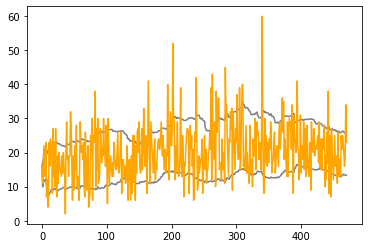

p =  [0.15286624203821655, 0.70276008492569, 0.14437367303609341]
length =  471
y = ax + b model
a =  [0.1500054]
b =  0.08491402319360425


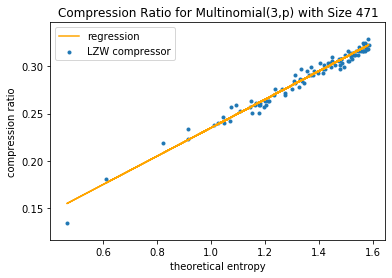

compression ratio:  0.2611464968152866
estimated entropy:  1.1792205623683385
P(e) lower bound :  0.2994777464061724
P(e) upper bound :  0.29723991507430997
--------------------------

John Wall


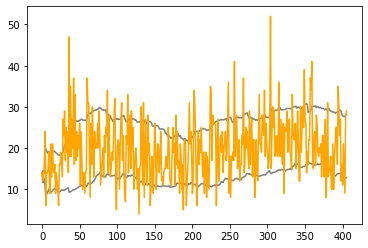

p =  [0.13793103448275862, 0.6921182266009852, 0.16995073891625614]
length =  406
y = ax + b model
a =  [0.15608239]
b =  0.08637024479351779


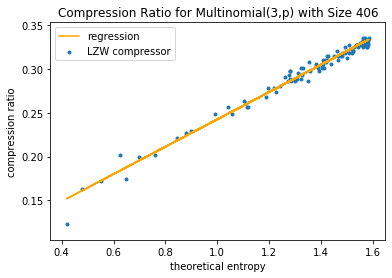

compression ratio:  0.27586206896551724
estimated entropy:  1.2164093411832244
P(e) lower bound :  0.31664257000430507
P(e) upper bound :  0.3078817733990148
--------------------------

Paul George


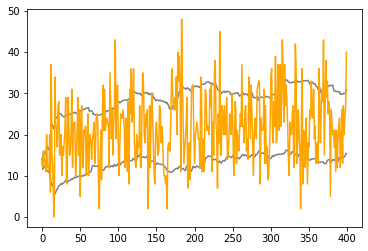

p =  [0.1575, 0.6625, 0.18]
length =  400
y = ax + b model
a =  [0.15250312]
b =  0.0906491425540249


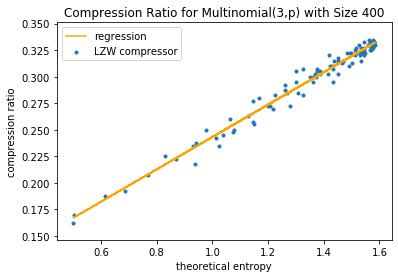

compression ratio:  0.2875
estimated entropy:  1.2920651297033399
P(e) lower bound :  0.3537523666265559
P(e) upper bound :  0.3375
--------------------------

DeMarcus Cousins


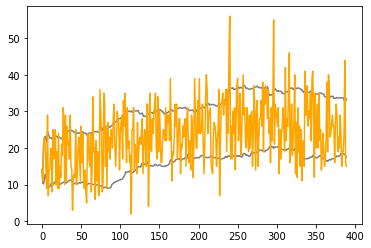

p =  [0.1564102564102564, 0.6512820512820513, 0.19230769230769232]
length =  390
y = ax + b model
a =  [0.15121875]
b =  0.09485360855230043


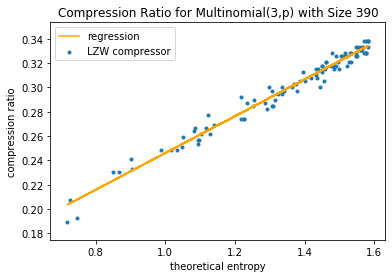

compression ratio:  0.28974358974358977
estimated entropy:  1.2902948362057225
P(e) lower bound :  0.35279929617144706
P(e) upper bound :  0.3487179487179487
--------------------------

Rudy Gobert


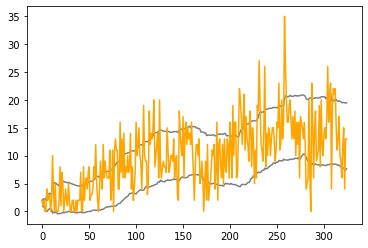

p =  [0.10153846153846154, 0.6861538461538461, 0.2123076923076923]
length =  325
y = ax + b model
a =  [0.16224828]
b =  0.09162880664873455


compression ratio:  0.28615384615384615
estimated entropy:  1.2022027147877976
P(e) lower bound :  0.3099830464272129
P(e) upper bound :  0.31384615384615383
--------------------------

Kyle Lowry


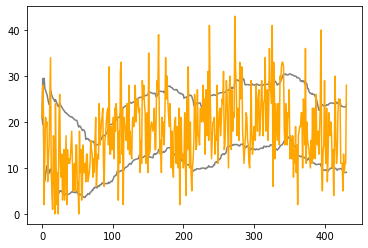

p =  [0.15046296296296297, 0.6828703703703703, 0.16666666666666666]
length =  432
y = ax + b model
a =  [0.14363542]
b =  0.09916316782458834


compression ratio:  0.2708333333333333
estimated entropy:  1.202074468775014
P(e) lower bound :  0.309924341428031
P(e) upper bound :  0.31712962962962965
--------------------------

Paul Millsap


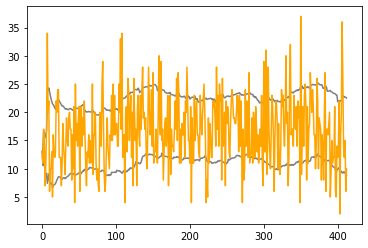

p =  [0.162227602905569, 0.6900726392251816, 0.14769975786924938]
length =  413
y = ax + b model
a =  [0.15240568]
b =  0.08943829976796874


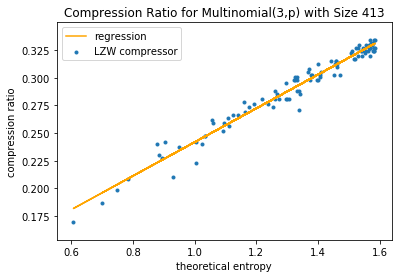

compression ratio:  0.2784503631961259
estimated entropy:  1.2430314839608576
P(e) lower bound :  0.329523599414772
P(e) upper bound :  0.3099273607748184
--------------------------

Blake Griffin


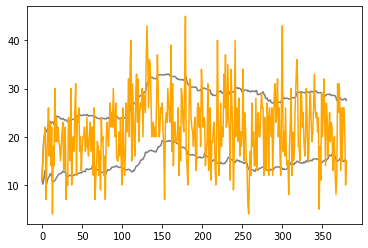

p =  [0.14698162729658792, 0.7007874015748031, 0.15223097112860892]
length =  381
y = ax + b model
a =  [0.15585085]
b =  0.08994094906052469


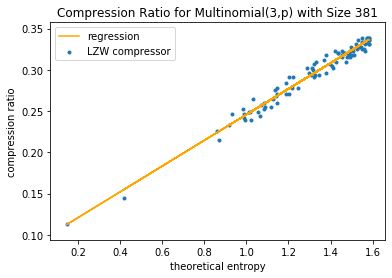

compression ratio:  0.2782152230971129
estimated entropy:  1.2108547125909968
P(e) lower bound :  0.31401898490639213
P(e) upper bound :  0.2992125984251969
--------------------------

Damian Lillard


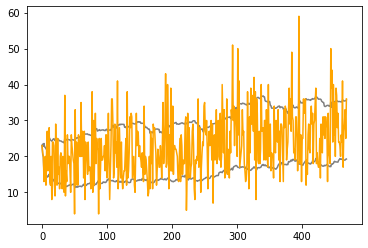

p =  [0.14072494669509594, 0.6886993603411514, 0.17057569296375266]
length =  469
y = ax + b model
a =  [0.14414538]
b =  0.09279945774564838


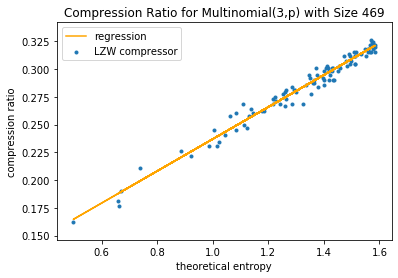

compression ratio:  0.27078891257995735
estimated entropy:  1.2372347728159998
P(e) lower bound :  0.3266714580816803
P(e) upper bound :  0.3113006396588486
--------------------------

DeAndre Jordan


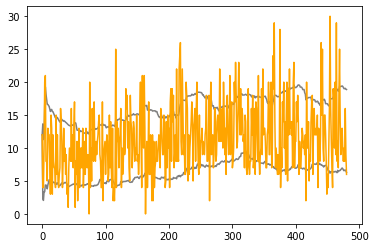

p =  [0.16216216216216217, 0.6611226611226612, 0.17671517671517672]
length =  481
y = ax + b model
a =  [0.14183663]
b =  0.09568636027365465


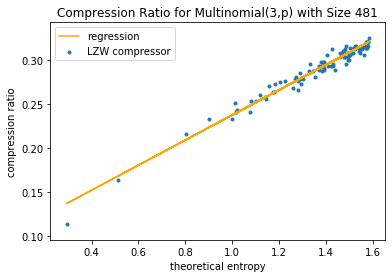

compression ratio:  0.2785862785862786
estimated entropy:  1.292208371903368
P(e) lower bound :  0.35382673301663453
P(e) upper bound :  0.3388773388773389
--------------------------

Kyrie Irving


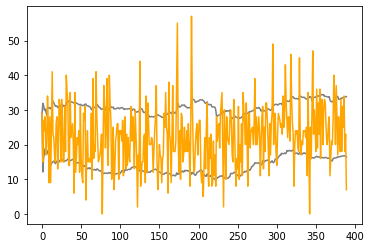

p =  [0.14871794871794872, 0.7128205128205128, 0.13846153846153847]
length =  390
y = ax + b model
a =  [0.15155209]
b =  0.09460970471781227


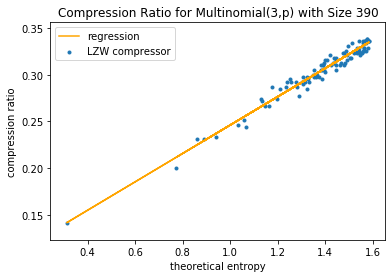

compression ratio:  0.2743589743589744
estimated entropy:  1.1925504505113393
P(e) lower bound :  0.30552224224595287
P(e) upper bound :  0.28717948717948716
--------------------------

Al Horford


p =  [0.1745635910224439, 0.6758104738154613, 0.14962593516209477]
length =  401
y = ax + b model
a =  [0.1562556]
b =  0.08696711997904807


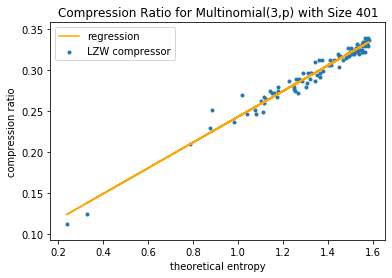

compression ratio:  0.2793017456359102
estimated entropy:  1.234607391191824
P(e) lower bound :  0.32539998802626474
P(e) upper bound :  0.32418952618453867
--------------------------

DeMar DeRozan


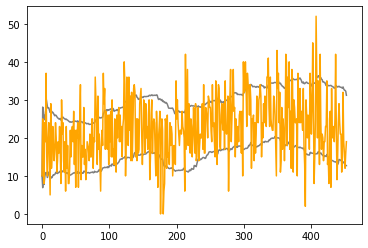

p =  [0.1368653421633554, 0.6975717439293598, 0.16556291390728478]
length =  453
y = ax + b model
a =  [0.15328849]
b =  0.08177589945128769


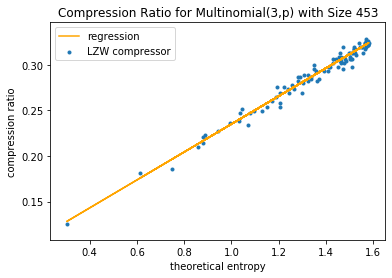

compression ratio:  0.2671081677704194
estimated entropy:  1.212072544449695
P(e) lower bound :  0.314600612424544
P(e) upper bound :  0.30242825607064017
--------------------------

Kevin Love


p =  [0.1721311475409836, 0.6666666666666666, 0.16120218579234974]
length =  366
y = ax + b model
a =  [0.15460894]
b =  0.09437090063485737


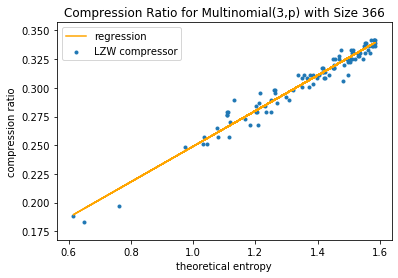

compression ratio:  0.2896174863387978
estimated entropy:  1.266642726900458
P(e) lower bound :  0.3404498740972238
P(e) upper bound :  0.33333333333333337
--------------------------

Andre Drummond


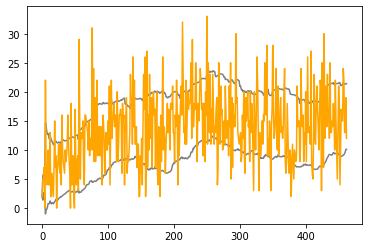

p =  [0.12958963282937366, 0.7084233261339092, 0.16198704103671707]
length =  463
y = ax + b model
a =  [0.14273648]
b =  0.09635518588096065


compression ratio:  0.2591792656587473
estimated entropy:  1.1484974980479117
P(e) lower bound :  0.2859686628992247
P(e) upper bound :  0.29157667386609076
--------------------------

Carmelo Anthony


p =  [0.1715686274509804, 0.6936274509803921, 0.13480392156862744]
length =  408
y = ax + b model
a =  [0.15123124]
b =  0.09201379372389853


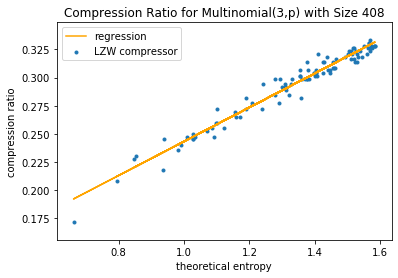

compression ratio:  0.27205882352941174
estimated entropy:  1.196087265622566
P(e) lower bound :  0.3071499839347179
P(e) upper bound :  0.30637254901960786
--------------------------

LaMarcus Aldridge


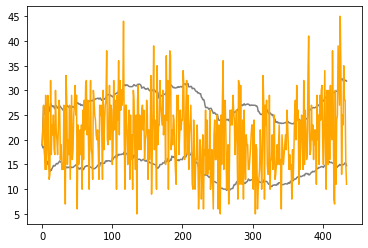

p =  [0.16551724137931034, 0.6413793103448275, 0.19310344827586207]
length =  435
y = ax + b model
a =  [0.15827025]
b =  0.07798402446361533


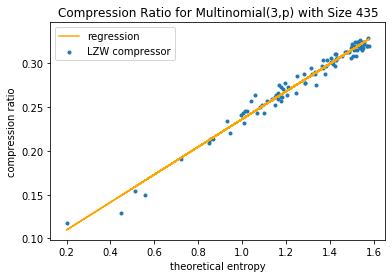

compression ratio:  0.2827586206896552
estimated entropy:  1.2935811938495343
P(e) lower bound :  0.3545584626640885
P(e) upper bound :  0.3586206896551724
--------------------------

Kemba Walker


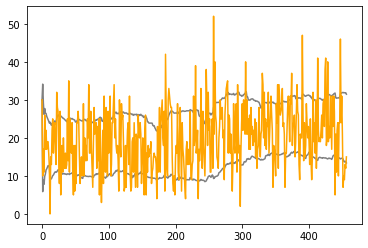

p =  [0.13566739606126915, 0.6980306345733042, 0.16630196936542668]
length =  457
y = ax + b model
a =  [0.14606559]
b =  0.09135383669022262


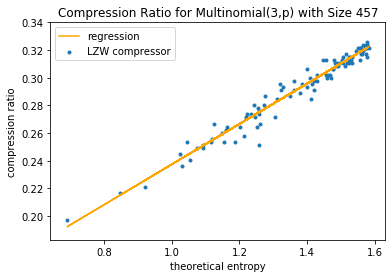

compression ratio:  0.2603938730853392
estimated entropy:  1.1652974373584721
P(e) lower bound :  0.29328317729360515
P(e) upper bound :  0.30196936542669583
--------------------------

Eric Bledsoe


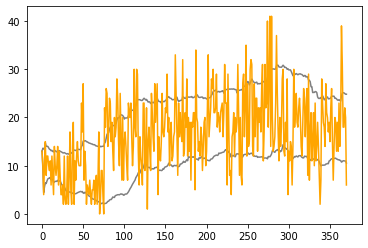

p =  [0.15633423180592992, 0.6657681940700808, 0.1778975741239892]
length =  371
y = ax + b model
a =  [0.14945125]
b =  0.10100220545166197


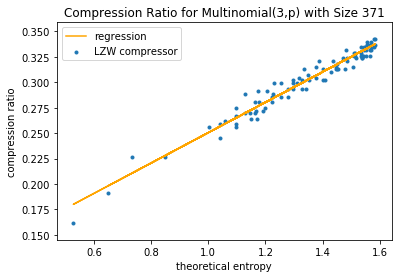

compression ratio:  0.2857142857142857
estimated entropy:  1.240648228154296
P(e) lower bound :  0.32835462417727207
P(e) upper bound :  0.33423180592991913
--------------------------

Dwight Howard


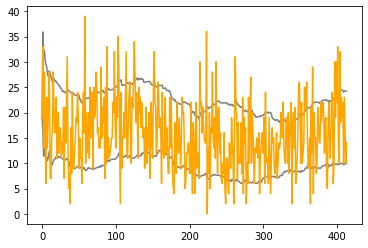

p =  [0.15942028985507245, 0.6859903381642513, 0.15458937198067632]
length =  414
y = ax + b model
a =  [0.15387126]
b =  0.08671248680189964


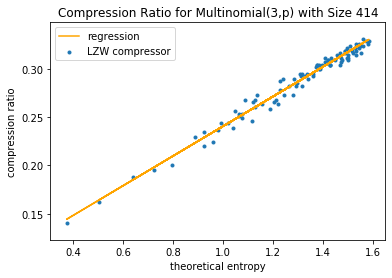

compression ratio:  0.27053140096618356
estimated entropy:  1.1969255521056212
P(e) lower bound :  0.30753179574385386
P(e) upper bound :  0.31400966183574874
--------------------------

Eric Gordon


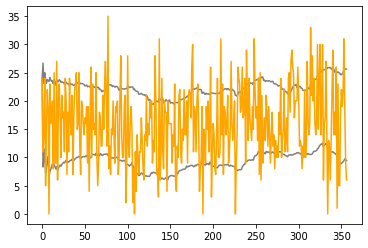

p =  [0.15966386554621848, 0.6610644257703081, 0.1792717086834734]
length =  357
y = ax + b model
a =  [0.15667844]
b =  0.09311245579852159


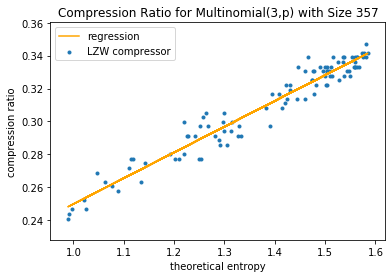

compression ratio:  0.2913165266106443
estimated entropy:  1.2715049638061715
P(e) lower bound :  0.34294474692198285
P(e) upper bound :  0.3389355742296919
--------------------------

George Hill


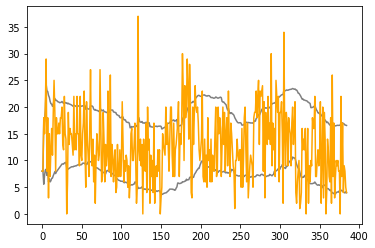

p =  [0.17922077922077922, 0.6545454545454545, 0.16623376623376623]
length =  385
y = ax + b model
a =  [0.15427083]
b =  0.09232737112732892


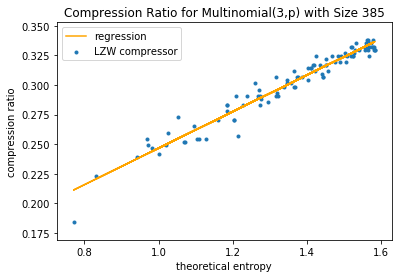

compression ratio:  0.2831168831168831
estimated entropy:  1.2425122046341874
P(e) lower bound :  0.32926284242172066
P(e) upper bound :  0.34545454545454546
--------------------------

Jeff Teague


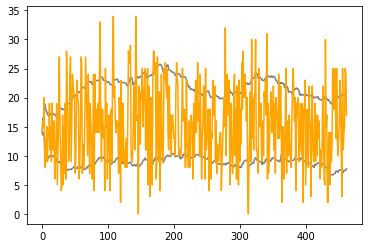

p =  [0.16846652267818574, 0.6544276457883369, 0.1771058315334773]
length =  463
y = ax + b model
a =  [0.14989371]
b =  0.08565425102097438


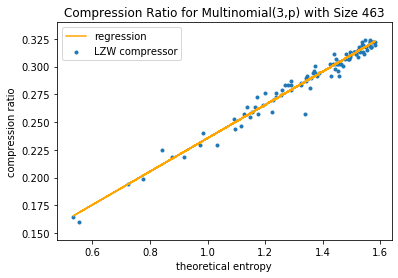

compression ratio:  0.28293736501079914
estimated entropy:  1.316959787866491
P(e) lower bound :  0.36736677622003777
P(e) upper bound :  0.34557235421166305
--------------------------

Andrew Wiggins


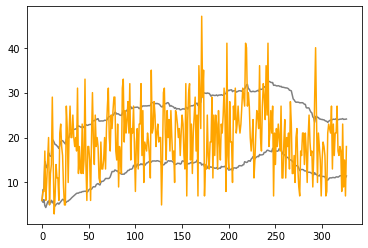

p =  [0.1437308868501529, 0.6880733944954128, 0.16819571865443425]
length =  327
y = ax + b model
a =  [0.15422493]
b =  0.1035208969751234


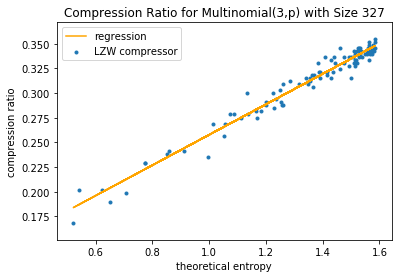

compression ratio:  0.290519877675841
estimated entropy:  1.2168220883559766
P(e) lower bound :  0.316833282923144
P(e) upper bound :  0.3119266055045872
--------------------------

Serge Ibaka


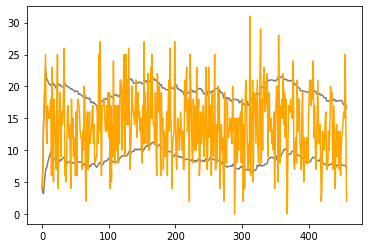

p =  [0.16593886462882096, 0.6834061135371179, 0.15065502183406113]
length =  458
y = ax + b model
a =  [0.14981527]
b =  0.08616241114836018


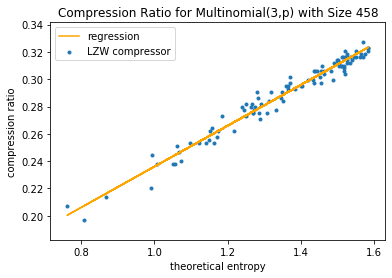

compression ratio:  0.2685589519650655
estimated entropy:  1.2216899503880012
P(e) lower bound :  0.31916206924900464
P(e) upper bound :  0.3165938864628821
--------------------------

Avery Bradley


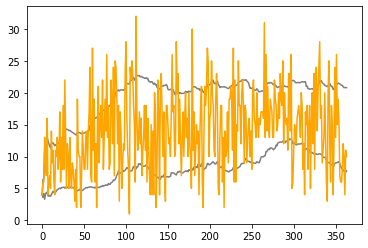

p =  [0.15934065934065933, 0.6538461538461539, 0.18681318681318682]
length =  364
y = ax + b model
a =  [0.15514891]
b =  0.09278158637343534


compression ratio:  0.2967032967032967
estimated entropy:  1.3133769797601733
P(e) lower bound :  0.36536401066766705
P(e) upper bound :  0.34615384615384615
--------------------------

Trevor Ariza


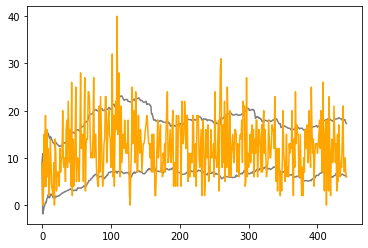

p =  [0.15575620767494355, 0.6839729119638827, 0.16027088036117382]
length =  443
y = ax + b model
a =  [0.14711058]
b =  0.09182758327181911


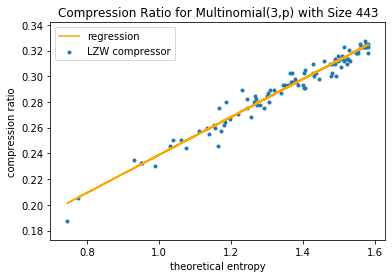

compression ratio:  0.27539503386004516
estimated entropy:  1.251520632039041
P(e) lower bound :  0.332804766370742
P(e) upper bound :  0.31602708803611734
--------------------------

Devin Booker


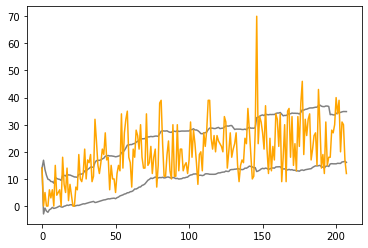

p =  [0.0673076923076923, 0.7307692307692307, 0.20192307692307693]
length =  208
y = ax + b model
a =  [0.17235873]
b =  0.1119817273479437


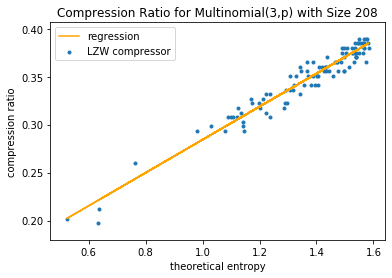

compression ratio:  0.28365384615384615
estimated entropy:  1.0156674748012986
P(e) lower bound :  0.23312578514266488
P(e) upper bound :  0.2692307692307692
--------------------------

Bradley Beal


p =  [0.14285714285714285, 0.6847290640394089, 0.1724137931034483]
length =  406
y = ax + b model
a =  [0.146696]
b =  0.09950086211508055


compression ratio:  0.27832512315270935
estimated entropy:  1.2233307398746422
P(e) lower bound :  0.31993936405488455
P(e) upper bound :  0.31527093596059114
--------------------------

Karl-Anthony Towns


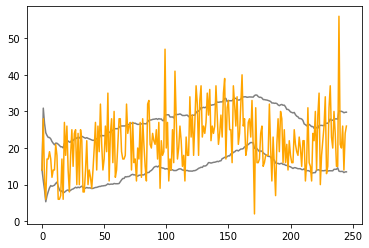

p =  [0.14227642276422764, 0.6585365853658537, 0.1991869918699187]
length =  246
y = ax + b model
a =  [0.16156016]
b =  0.11389123027476053


compression ratio:  0.32113821138211385
estimated entropy:  1.2855956244528555
P(e) lower bound :  0.35030972866707566
P(e) upper bound :  0.3414634146341463
--------------------------

Marc Gasol


p =  [0.16706443914081145, 0.6754176610978521, 0.1575178997613365]
length =  419
y = ax + b model
a =  [0.14813275]
b =  0.09478330386192146


compression ratio:  0.28162291169451076
estimated entropy:  1.2629805157774159
P(e) lower bound :  0.33858832428993657
P(e) upper bound :  0.32458233890214794
--------------------------

Khris Middleton


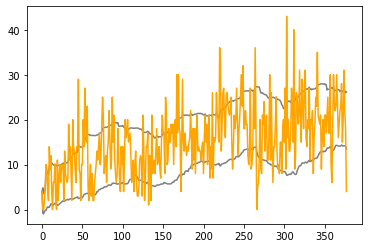

p =  [0.13227513227513227, 0.6507936507936508, 0.21693121693121692]
length =  378
y = ax + b model
a =  [0.15521464]
b =  0.09094689955208543


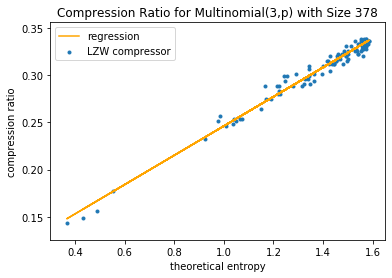

compression ratio:  0.28835978835978837
estimated entropy:  1.273949254478778
P(e) lower bound :  0.3442117711304346
P(e) upper bound :  0.3492063492063492
--------------------------



In [470]:
metric = "PTS_G"

alpha = 1
window = 50
#############
lbs_ternary=[]
for player_name in players:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_gamma, upper, lower = get_gamma(player_data, player_data, alpha, window)
    size = len(player_gamma)
    p0 = np.sum(np.array(player_gamma) == -1)/size
    p1 = np.sum(np.array(player_gamma) == 0)/size
    p2 = np.sum(np.array(player_gamma) == 1)/size
    p = [p0, p1, p2]
    ub = p0+p2
    
    plt.plot(upper, color="grey")
    plt.plot(lower, color="grey")
    plt.plot(player_data, color="orange")
    plt.show()
    
    # convert [-1, 0, 1] to [0, 1, 2]
    player_gamma_uncomp = list(np.array(player_gamma) + 1)
    player_gamma_string = list_to_string(player_gamma_uncomp)
    
    print("p = ", p)
    print("length = ", size)
    
    compressed = compress(player_gamma_string)
    compression_ratio = len(compressed)/len(player_gamma_string)    
    ent = get_entropy_ternary(size, compression_ratio)
    lb = inverse_binary_entropy_1(ent[0], a=0.001)
    lbs_ternary.append(lb)
    
    print("compression ratio: ", compression_ratio)
    print("estimated entropy: ", ent[0])
    print("P(e) lower bound : ", lb)
    print("P(e) upper bound : ", ub)
    print("--------------------------")
    print()

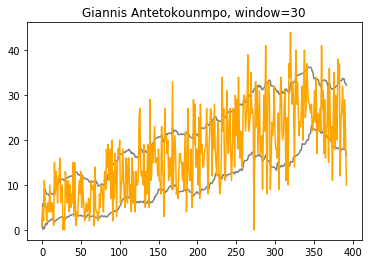

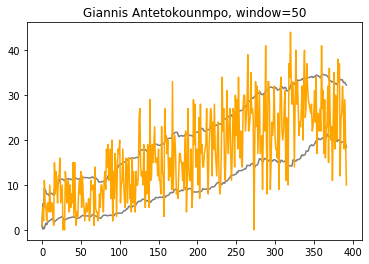

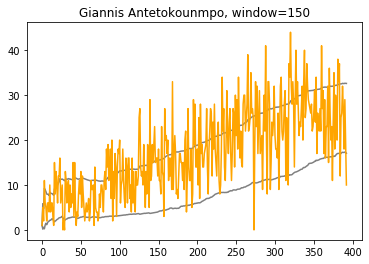

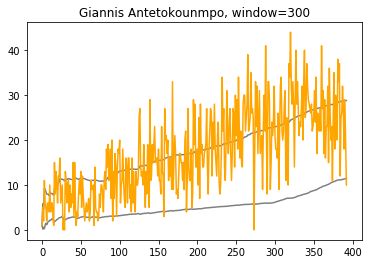

In [477]:
player_name = "Giannis Antetokounmpo"

for window in [5, 10, 30, 50, 150, 300]:
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_gamma, upper, lower = get_gamma(player_data, player_data, alpha, window)

    plt.title("{}, window={}".format(player_name, window))
    plt.plot(upper, color="grey")
    plt.plot(lower, color="grey")
    plt.plot(player_data, color="orange")
    plt.show()

LeBron James


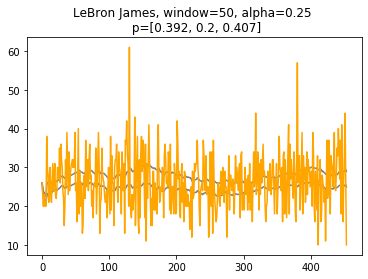

--------------------------

LeBron James


--------------------------

LeBron James


--------------------------

LeBron James


--------------------------

LeBron James


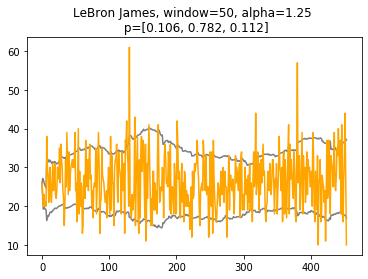

--------------------------

LeBron James


--------------------------



In [494]:
player_name = "LeBron James"
metric = "PTS_G"
window = 50
#############
lbs_ternary=[]
for alpha in [0.25, 0.5,0.75,1,1.25, 1.5]:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    player_gamma, upper, lower = get_gamma(player_data, player_data, alpha, window)
    size = len(player_gamma)
    p0 = np.sum(np.array(player_gamma) == -1)/size
    p1 = np.sum(np.array(player_gamma) == 0)/size
    p2 = np.sum(np.array(player_gamma) == 1)/size
    p = [p0.round(3), p1.round(3), p2.round(3)]
    ub = p0+p2
    
    plt.title("{}, window={}, alpha={} \n p={}".format(player_name, window, alpha, p))
    plt.plot(upper, color="grey")
    plt.plot(lower, color="grey")
    plt.plot(player_data, color="orange")
    plt.show()
    
    # convert [-1, 0, 1] to [0, 1, 2]
    player_gamma_uncomp = list(np.array(player_gamma) + 1)
    player_gamma_string = list_to_string(player_gamma_uncomp)
    
#     print("p = ", p)
#     print("length = ", size)
    
#     compressed = compress(player_gamma_string)
#     compression_ratio = len(compressed)/len(player_gamma_string)    
#     ent = get_entropy_ternary(size, compression_ratio)
#     lb = inverse_binary_entropy_1(ent[0], a=0.001)
#     lbs_ternary.append(lb)
    
#     print("compression ratio: ", compression_ratio)
#     print("estimated entropy: ", ent[0])
#     print("P(e) lower bound : ", lb)
#     print("P(e) upper bound : ", ub)
    print("--------------------------")
    print()

In [403]:
def experiment(player_data, alpha, window, iteration=100):
    player_gamma = get_gamma(player_data, player_data, alpha, window)
    size = len(player_gamma)
    p0 = np.sum(np.array(player_gamma) == -1)/size
    p1 = np.sum(np.array(player_gamma) == 0)/size
    p2 = np.sum(np.array(player_gamma) == 1)/size
    p = [p0, p1, p2]
    ub = p0+p2

    # convert [-1, 0, 1] to [0, 1, 2]
    player_gamma_uncomp = list(np.array(player_gamma) + 1)
    player_gamma_string = list_to_string(player_gamma_uncomp)

    print("p = ", p)
    print("length = ", size)
    compressed = compress(player_gamma_string)
    compression_ratio = len(compressed)/len(player_gamma_string)

    lb_list=[]
    ent_list=[]
    for i in range(iteration):
        ent = get_entropy_ternary(size, compression_ratio, show_graph=False)
        lb = inverse_binary_entropy_1(ent[0], a=0.001)
        lb_list.append(lb)
        ent_list.append(ent[0])

    plt.title("Histogram of estimated entropy")
    plt.hist(ent_list)
    plt.axvline(entropy(p), color="red", label="empirical entropy = {}".format(np.round(entropy(p), 5)))
    plt.axvline(np.mean(ent_list), color="blue", label="mean entropy = {}".format(np.round(np.mean(ent_list), 5)))

    plt.legend()
    plt.show()

    plt.title("Histogram of calculated P(e) lower bound")
    plt.hist(lb_list)
    plt.axvline(np.mean(lb_list), color="blue", label="mean lower bound = {}".format(np.round(np.mean(lb_list), 5)))
    plt.legend()
    plt.show()

    print("P(e) mean lower bound : ", np.mean(lb_list))
    print("P(e) upper bound : ", ub)
    print("--------------------------")
    print()
    return ent_list, lb_list, ub

p =  [0.11136363636363636, 0.6818181818181818, 0.20681818181818182]
length =  440


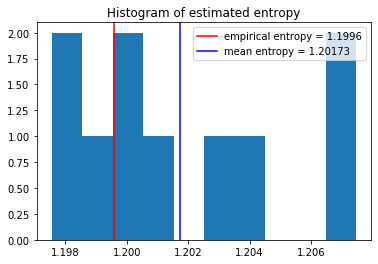

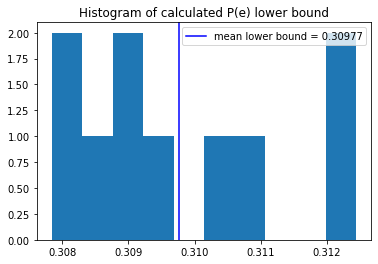

P(e) mean lower bound :  0.30976589247510095
P(e) upper bound :  0.3181818181818182
--------------------------

p =  [0.1590909090909091, 0.5636363636363636, 0.2772727272727273]
length =  440


In [ ]:
player_name = "Stephen Curry"
metric = "PTS_G"

alpha, window = 1,5
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)

alpha, window = 0.75,5
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)

alpha, window = 0.5,5
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)

p =  [0.0400890868596882, 0.9220489977728286, 0.0378619153674833]
length =  449


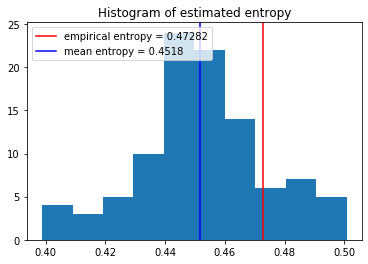

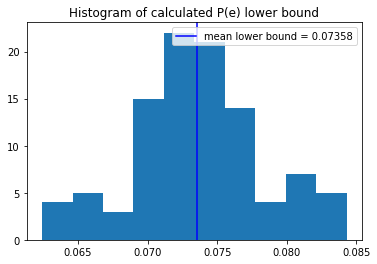

P(e) mean lower bound :  0.07357735898026074
P(e) upper bound :  0.0779510022271715
--------------------------

p =  [0.16481069042316257, 0.6681514476614699, 0.16703786191536749]
length =  449


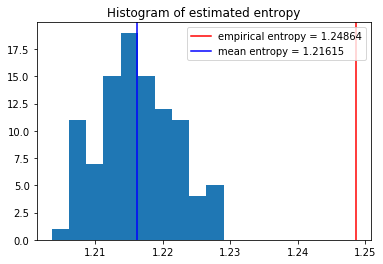

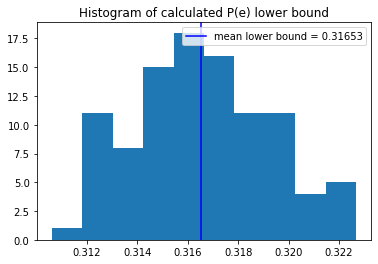

P(e) mean lower bound :  0.3165344260223582
P(e) upper bound :  0.33184855233853006
--------------------------

p =  [0.32516703786191536, 0.32962138084632514, 0.34521158129175944]
length =  449


KeyboardInterrupt: 

In [364]:
player_name = "LeBron James"
metric = "PTS_G"

alpha, window = 1.5,5
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)

alpha, window = 1,5
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)

alpha, window = 0.5,5
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)

LeBron James
p =  [0.16481069042316257, 0.6681514476614699, 0.16703786191536749]
length =  449


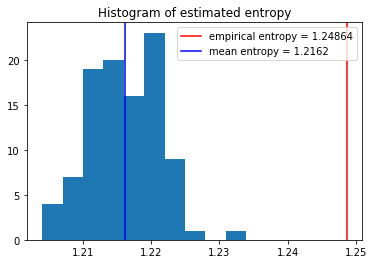

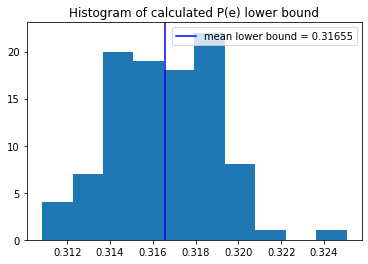

P(e) mean lower bound :  0.31655428258974655
P(e) upper bound :  0.33184855233853006
--------------------------

Kevin Durant
p =  [0.16321243523316062, 0.6761658031088082, 0.16062176165803108]
length =  386


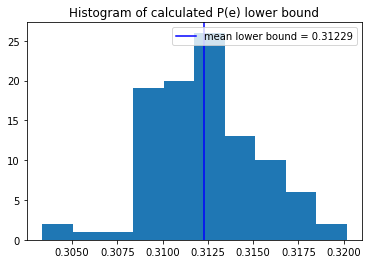

P(e) mean lower bound :  0.3122935985729912
P(e) upper bound :  0.3238341968911917
--------------------------

Stephen Curry
p =  [0.15, 0.675, 0.175]
length =  440


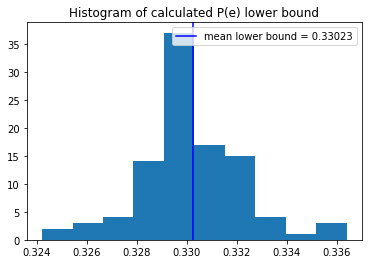

P(e) mean lower bound :  0.33022894817662946
P(e) upper bound :  0.32499999999999996
--------------------------

Russell Westbrook
p =  [0.16009280742459397, 0.6566125290023201, 0.18329466357308585]
length =  431


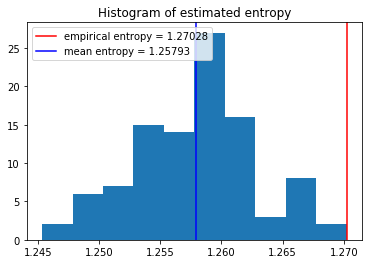

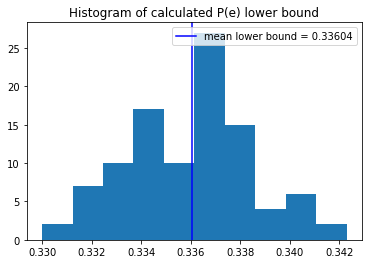

P(e) mean lower bound :  0.3360360124347189
P(e) upper bound :  0.34338747099767986
--------------------------

James Harden
p =  [0.16233766233766234, 0.6753246753246753, 0.16233766233766234]
length =  462


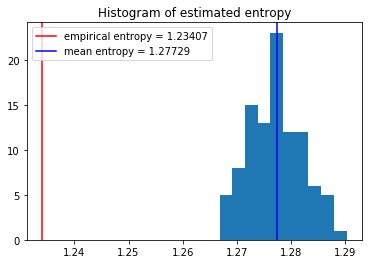

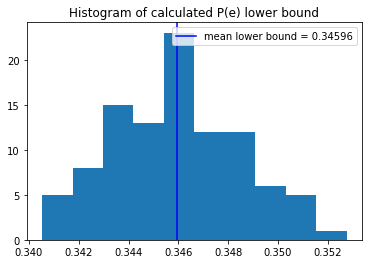

P(e) mean lower bound :  0.34595832621981343
P(e) upper bound :  0.3246753246753247
--------------------------

Giannis Antetokounmpo
p =  [0.16494845360824742, 0.6520618556701031, 0.18298969072164947]
length =  388


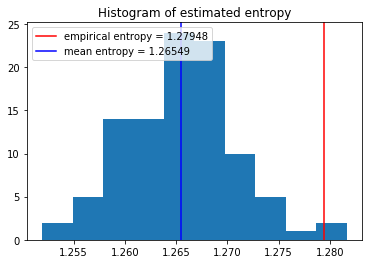

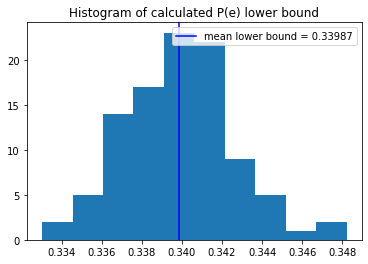

P(e) mean lower bound :  0.33987347344717206
P(e) upper bound :  0.3479381443298969
--------------------------

Anthony Davis
p =  [0.17037037037037037, 0.6666666666666666, 0.16296296296296298]
length =  405


P(e) mean lower bound :  0.3342411482977401
P(e) upper bound :  0.33333333333333337
--------------------------

Jimmy Butler
p =  [0.1650485436893204, 0.6747572815533981, 0.16019417475728157]
length =  412


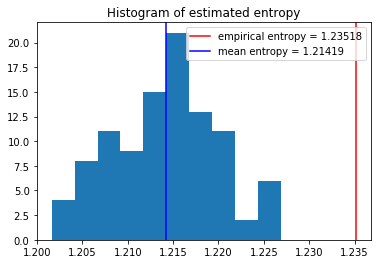

P(e) mean lower bound :  0.3156097893420183
P(e) upper bound :  0.32524271844660196
--------------------------

Draymond Green
p =  [0.14502164502164502, 0.6645021645021645, 0.19047619047619047]
length =  462


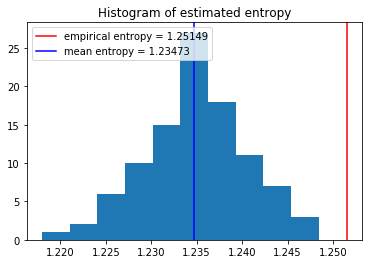

P(e) mean lower bound :  0.325435930283253
P(e) upper bound :  0.3354978354978355
--------------------------

Chris Paul
p =  [0.1691542288557214, 0.6691542288557214, 0.16169154228855723]
length =  402


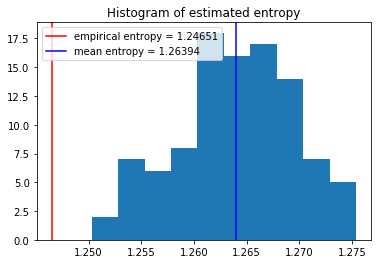

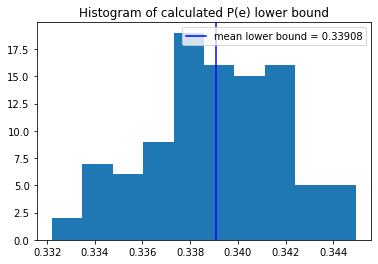

P(e) mean lower bound :  0.33908116637232666
P(e) upper bound :  0.3308457711442786
--------------------------

Klay Thompson
p =  [0.1459227467811159, 0.6781115879828327, 0.1759656652360515]
length =  466


KeyboardInterrupt: 

In [361]:
metric = "PTS_G"
alpha = 1
window = 5

lbs = []
ubs = []
for player_name in players:
    print(player_name)
    player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
    ent_list, lb_list, ub = experiment(player_data, alpha, window, iteration=100)
    
    lbs.append(np.mean(lb_list))
    ubs.append(ub)

In [362]:
plt.title("P(e) lower bounds and upper bounds distribution, ternary")
plt.hist(lbs, alpha=0.5, color="blue", label="lower bounds")
plt.hist(ubs, alpha=0.5, color="orange", label="upper bounds")

plt.axvline(np.mean(lbs), color="blue", label="mean = {}".format(np.round(np.mean(lbs), 3)))
plt.axvline(np.mean(ubs), color="red", label="mean = {}".format(np.round(np.mean(ubs), 3)))

# plt.xlim(0.15,0.40)
plt.legend()
plt.show()

LeBron James
p =  0.16481069042316257 0.6681514476614699 0.16703786191536749
length =  449
y = ax + b model
a =  [0.14400877]
b =  0.09631425544920985


compression ratio:  0.26948775055679286
estimated entropy:  1.208875801520357
P(e) lower bound :  0.313087377029226
--------------------------

Kevin Durant
p =  0.16321243523316062 0.6761658031088082 0.16062176165803108
length =  386
y = ax + b model
a =  [0.15433035]
b =  0.09134239287456988


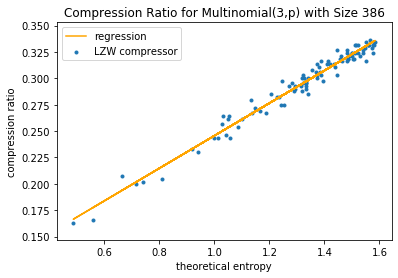

compression ratio:  0.2772020725388601
estimated entropy:  1.2074902248126014
P(e) lower bound :  0.3124499794081051
--------------------------

Stephen Curry
p =  0.15 0.675 0.175
length =  440
y = ax + b model
a =  [0.15125518]
b =  0.08678898664536566


compression ratio:  0.275
estimated entropy:  1.2477419371427492
P(e) lower bound :  0.33092166788166477
--------------------------

Russell Westbrook
p =  0.16009280742459397 0.6566125290023201 0.18329466357308585
length =  431
y = ax + b model
a =  [0.14403286]
b =  0.09928774247753078


compression ratio:  0.27842227378190254
estimated entropy:  1.247672001392043
P(e) lower bound :  0.3308987849404648
--------------------------

James Harden
p =  0.16233766233766234 0.6753246753246753 0.16233766233766234
length =  462
y = ax + b model
a =  [0.15348564]
b =  0.08094729930239122


compression ratio:  0.27705627705627706
estimated entropy:  1.2800250123171775
P(e) lower bound :  0.34736781836082264
--------------------------

Giannis Antetokounmpo
p =  0.16494845360824742 0.6520618556701031 0.18298969072164947
length =  388
y = ax + b model
a =  [0.14941069]
b =  0.09741997688110887


compression ratio:  0.2860824742268041
estimated entropy:  1.265491516910802
P(e) lower bound :  0.33985386478377305
--------------------------

Anthony Davis
p =  0.17037037037037037 0.6666666666666666 0.16296296296296298
length =  405
y = ax + b model
a =  [0.15292708]
b =  0.09009104849051358


compression ratio:  0.2814814814814815
estimated entropy:  1.254086818506946
P(e) lower bound :  0.3341015043120587
--------------------------

Jimmy Butler
p =  0.1650485436893204 0.6747572815533981 0.16019417475728157
length =  412
y = ax + b model
a =  [0.14580673]
b =  0.09863482866907794


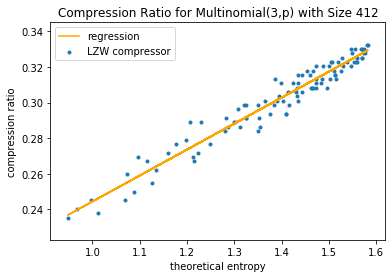

compression ratio:  0.27427184466019416
estimated entropy:  1.2141157970204612
P(e) lower bound :  0.315563431375766
--------------------------

Draymond Green
p =  0.14502164502164502 0.6645021645021645 0.19047619047619047
length =  462
y = ax + b model
a =  [0.14385144]
b =  0.09461472331286933


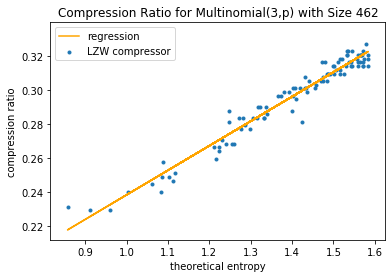

compression ratio:  0.27056277056277056
estimated entropy:  1.2304699008190214
P(e) lower bound :  0.32337594329039654
--------------------------

Chris Paul
p =  0.1691542288557214 0.6691542288557214 0.16169154228855723
length =  402
y = ax + b model
a =  [0.15080864]
b =  0.09405093366624884


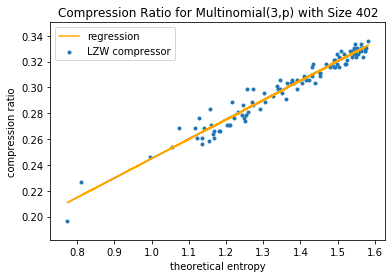

compression ratio:  0.2835820895522388
estimated entropy:  1.2612030302029655
P(e) lower bound :  0.3376839567600256
--------------------------

Klay Thompson
p =  0.1459227467811159 0.6781115879828327 0.1759656652360515
length =  466
y = ax + b model
a =  [0.14506376]
b =  0.09239127214750045


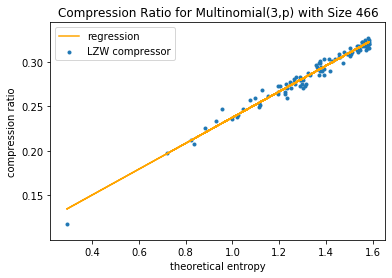

compression ratio:  0.26609442060085836
estimated entropy:  1.2009429031252552
P(e) lower bound :  0.3094067244398249
--------------------------

John Wall
p =  0.1571072319201995 0.6758104738154613 0.16708229426433915
length =  401
y = ax + b model
a =  [0.14641823]
b =  0.10043882722892461


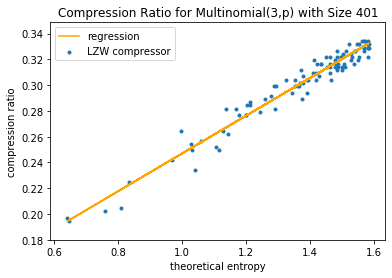

compression ratio:  0.2743142144638404
estimated entropy:  1.1948784498270046
P(e) lower bound :  0.3066000488228609
--------------------------

Paul George
p =  0.1620253164556962 0.6632911392405063 0.17468354430379746
length =  395
y = ax + b model
a =  [0.1520232]
b =  0.09373072105839347


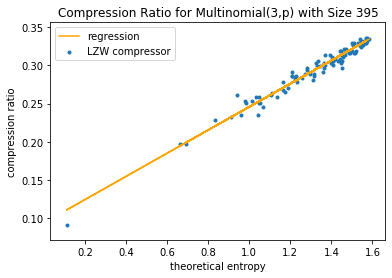

compression ratio:  0.2759493670886076
estimated entropy:  1.2027622083023466
P(e) lower bound :  0.31023925359280624
--------------------------

DeMarcus Cousins
p =  0.15844155844155844 0.6987012987012987 0.14285714285714285
length =  385
y = ax + b model
a =  [0.14975924]
b =  0.09848370527541797


compression ratio:  0.2753246753246753
estimated entropy:  1.1872252216585766
P(e) lower bound :  0.30309285854376294
--------------------------

Rudy Gobert
p =  0.159375 0.675 0.165625
length =  320
y = ax + b model
a =  [0.16533473]
b =  0.08970056416247613


compression ratio:  0.29375
estimated entropy:  1.2377696318290452
P(e) lower bound :  0.32694026353265854
--------------------------

Kyle Lowry
p =  0.15690866510538642 0.65807962529274 0.18501170960187355
length =  427
y = ax + b model
a =  [0.14649524]
b =  0.09574118681757796


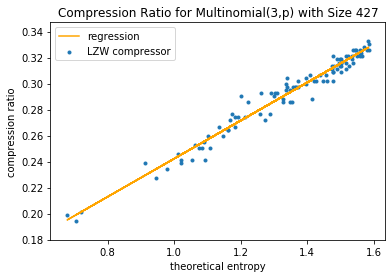

compression ratio:  0.2810304449648712
estimated entropy:  1.2671583860848383
P(e) lower bound :  0.3407194798659142
--------------------------

Paul Millsap
p =  0.15931372549019607 0.6495098039215687 0.19117647058823528
length =  408
y = ax + b model
a =  [0.14945202]
b =  0.0952569565135723


compression ratio:  0.28921568627450983
estimated entropy:  1.299052211667107
P(e) lower bound :  0.35751296944087146
--------------------------

Blake Griffin
p =  0.15425531914893617 0.6648936170212766 0.18085106382978725
length =  376
y = ax + b model
a =  [0.15666873]
b =  0.08946242358409245


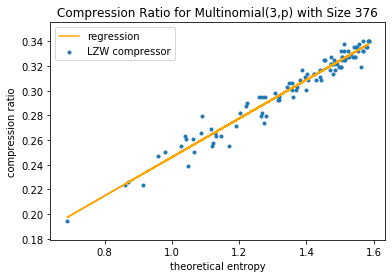

compression ratio:  0.2845744680851064
estimated entropy:  1.2495236254522724
P(e) lower bound :  0.3318080854208739
--------------------------

Damian Lillard
p =  0.16594827586206898 0.6724137931034483 0.16163793103448276
length =  464
y = ax + b model
a =  [0.14993326]
b =  0.08582671001506051


compression ratio:  0.26939655172413796
estimated entropy:  1.2273182952575032
P(e) lower bound :  0.3218548346589795
--------------------------

DeAndre Jordan
p =  0.13655462184873948 0.6848739495798319 0.17857142857142858
length =  476
y = ax + b model
a =  [0.14552304]
b =  0.08951851143475231


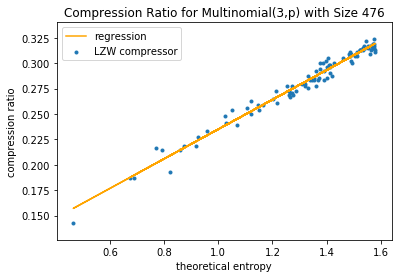

compression ratio:  0.2689075630252101
estimated entropy:  1.2350236442680917
P(e) lower bound :  0.3256046646764908
--------------------------

Kyrie Irving
p =  0.13506493506493505 0.6909090909090909 0.17402597402597403
length =  385
y = ax + b model
a =  [0.15811281]
b =  0.0866649135843508


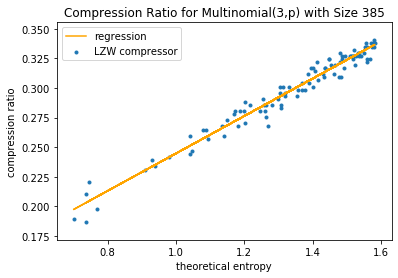

compression ratio:  0.2779220779220779
estimated entropy:  1.213898860913483
P(e) lower bound :  0.3154633357868962
--------------------------

Al Horford
p =  0.15151515151515152 0.6843434343434344 0.16414141414141414
length =  396
y = ax + b model
a =  [0.15279852]
b =  0.0918167688674848


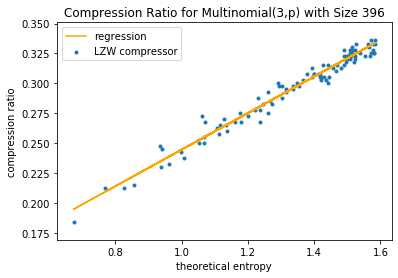

compression ratio:  0.2803030303030303
estimated entropy:  1.236673344022634
P(e) lower bound :  0.3264085293437344
--------------------------

DeMar DeRozan
p =  0.15848214285714285 0.7008928571428571 0.140625
length =  448
y = ax + b model
a =  [0.14796616]
b =  0.09043500274607591


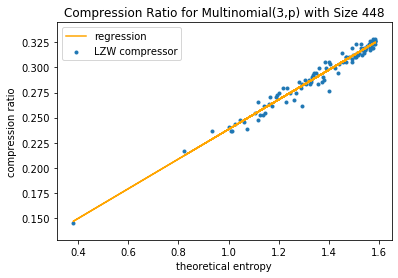

compression ratio:  0.26339285714285715
estimated entropy:  1.1747531812066727
P(e) lower bound :  0.29748603063559
--------------------------

Kevin Love
p =  0.14958448753462603 0.6759002770083102 0.1745152354570637
length =  361
y = ax + b model
a =  [0.15613893]
b =  0.0930034764285928


compression ratio:  0.29085872576177285
estimated entropy:  1.269328105804552
P(e) lower bound :  0.341836022690945
--------------------------

Andre Drummond
p =  0.14192139737991266 0.6877729257641921 0.1703056768558952
length =  458
y = ax + b model
a =  [0.14912208]
b =  0.0868035163323514


compression ratio:  0.2663755458515284
estimated entropy:  1.2066500679448477
P(e) lower bound :  0.3120434963666348
--------------------------

Carmelo Anthony
p =  0.16377171215880892 0.6575682382133995 0.17866004962779156
length =  403
y = ax + b model
a =  [0.15560128]
b =  0.0861692385165575


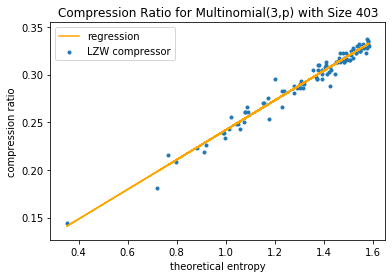

compression ratio:  0.2853598014888337
estimated entropy:  1.2816688618422183
P(e) lower bound :  0.34823648987003847
--------------------------

LaMarcus Aldridge
p =  0.16511627906976745 0.6790697674418604 0.1558139534883721
length =  430
y = ax + b model
a =  [0.15196728]
b =  0.08764667196190418


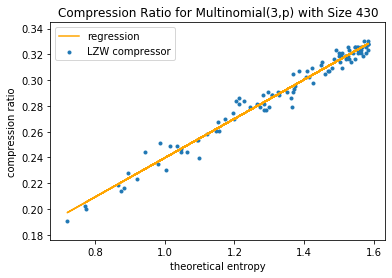

compression ratio:  0.26976744186046514
estimated entropy:  1.201727221767617
P(e) lower bound :  0.30976542982707794
--------------------------

Kemba Walker
p =  0.168141592920354 0.665929203539823 0.16592920353982302
length =  452
y = ax + b model
a =  [0.14559106]
b =  0.09332756495444472


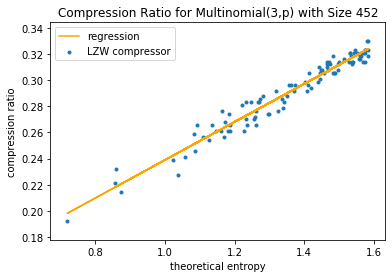

compression ratio:  0.2721238938053097
estimated entropy:  1.2335957479022617
P(e) lower bound :  0.32490846216045877
--------------------------

Eric Bledsoe
p =  0.16120218579234974 0.6639344262295082 0.17486338797814208
length =  366
y = ax + b model
a =  [0.14880534]
b =  0.10282986066398217


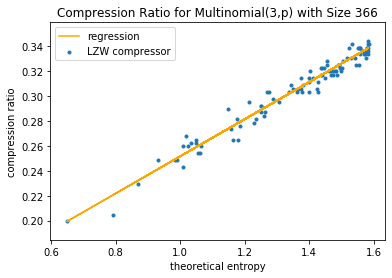

compression ratio:  0.2814207650273224
estimated entropy:  1.2056273302278222
P(e) lower bound :  0.3115736434930668
--------------------------

Dwight Howard
p =  0.1784841075794621 0.6454767726161369 0.17603911980440098
length =  409
y = ax + b model
a =  [0.14985676]
b =  0.09338957129976835


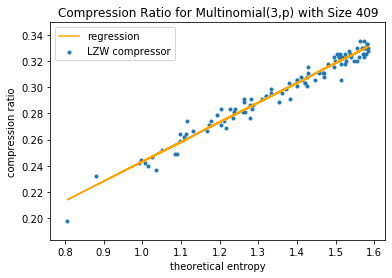

compression ratio:  0.2860635696821516
estimated entropy:  1.2878121270144653
P(e) lower bound :  0.351482994480961
--------------------------

Eric Gordon
p =  0.14772727272727273 0.6960227272727273 0.15625
length =  352
y = ax + b model
a =  [0.15898478]
b =  0.09000815070134746


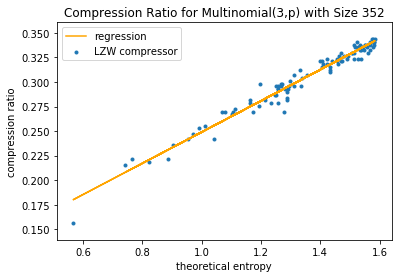

compression ratio:  0.2840909090909091
estimated entropy:  1.2249950851079345
P(e) lower bound :  0.320746488125831
--------------------------

George Hill
p =  0.1631578947368421 0.6736842105263158 0.1631578947368421
length =  380
y = ax + b model
a =  [0.15608885]
b =  0.08905174836615831


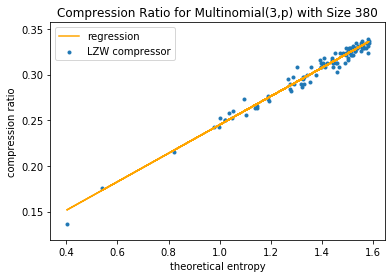

compression ratio:  0.28157894736842104
estimated entropy:  1.236932041642692
P(e) lower bound :  0.3265209568856576
--------------------------

Jeff Teague
p =  0.14410480349344978 0.6986899563318777 0.1572052401746725
length =  458
y = ax + b model
a =  [0.15239823]
b =  0.08269097943785628


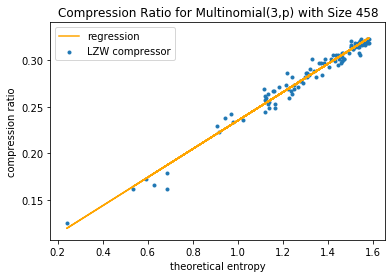

compression ratio:  0.2663755458515284
estimated entropy:  1.2081278927117092
P(e) lower bound :  0.31274320430023084
--------------------------

Andrew Wiggins
p =  0.15527950310559005 0.6739130434782609 0.17080745341614906
length =  322
y = ax + b model
a =  [0.16155109]
b =  0.0942128107115888


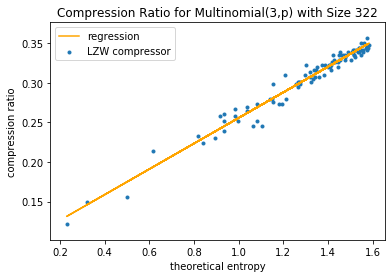

compression ratio:  0.2919254658385093
estimated entropy:  1.226713621216819
P(e) lower bound :  0.3215770944167053
--------------------------

Serge Ibaka
p =  0.16777041942604856 0.6578366445916115 0.17439293598233996
length =  453
y = ax + b model
a =  [0.1434058]
b =  0.09559786001137588


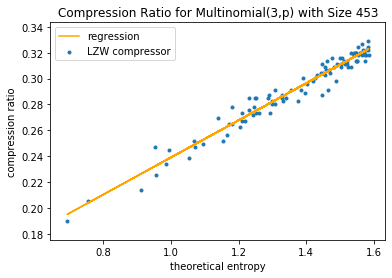

compression ratio:  0.2781456953642384
estimated entropy:  1.2767417713555673
P(e) lower bound :  0.34566107732496093
--------------------------

Avery Bradley
p =  0.17827298050139276 0.6462395543175488 0.17548746518105848
length =  359
y = ax + b model
a =  [0.15365367]
b =  0.09710176301041282


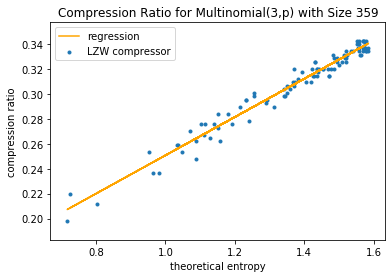

compression ratio:  0.3008356545961003
estimated entropy:  1.3272943127633814
P(e) lower bound :  0.37322888827719203
--------------------------

Trevor Ariza
p =  0.15296803652968036 0.6461187214611872 0.2009132420091324
length =  438
y = ax + b model
a =  [0.15249643]
b =  0.08608803721154071


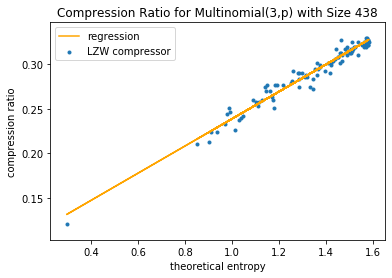

compression ratio:  0.2785388127853881
estimated entropy:  1.2648791574009934
P(e) lower bound :  0.33955787160235323
--------------------------

Devin Booker
p =  0.15270935960591134 0.6650246305418719 0.18226600985221675
length =  203
y = ax + b model
a =  [0.16150973]
b =  0.1286827171414236


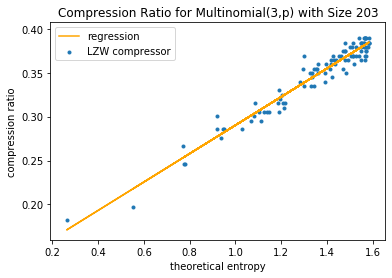

compression ratio:  0.33004926108374383
estimated entropy:  1.2519447732864846
P(e) lower bound :  0.3330250048800631
--------------------------

Bradley Beal
p =  0.16708229426433915 0.683291770573566 0.14962593516209477
length =  401
y = ax + b model
a =  [0.15256021]
b =  0.09142693076745778


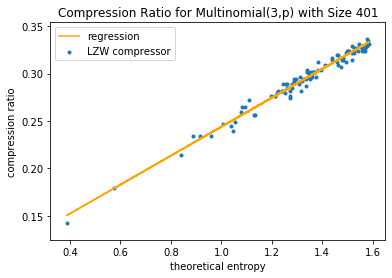

compression ratio:  0.27680798004987534
estimated entropy:  1.2177928867009873
P(e) lower bound :  0.31730177619132505
--------------------------

Karl-Anthony Towns
p =  0.14107883817427386 0.7012448132780082 0.15767634854771784
length =  241
y = ax + b model
a =  [0.16907502]
b =  0.10450615827702164


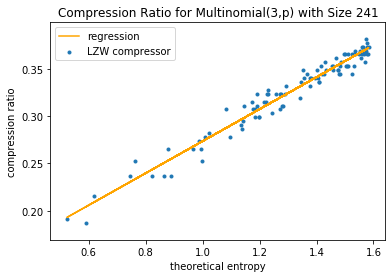

compression ratio:  0.3153526970954357
estimated entropy:  1.2496425219465683
P(e) lower bound :  0.33187448407540254
--------------------------

Marc Gasol
p =  0.16666666666666666 0.6763285024154589 0.1570048309178744
length =  414
y = ax + b model
a =  [0.14964362]
b =  0.09241258536215313


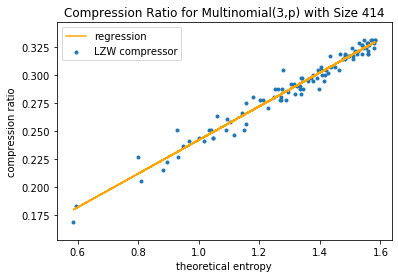

compression ratio:  0.2826086956521739
estimated entropy:  1.2724081736166677
P(e) lower bound :  0.34340994029937555
--------------------------

Khris Middleton
p =  0.16085790884718498 0.6246648793565683 0.21447721179624665
length =  373
y = ax + b model
a =  [0.15772249]
b =  0.0888017114755546


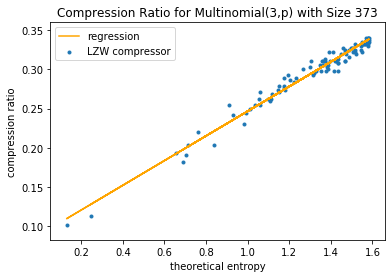

compression ratio:  0.29222520107238603
estimated entropy:  1.2903038751231304
P(e) lower bound :  0.35280396847895173
--------------------------



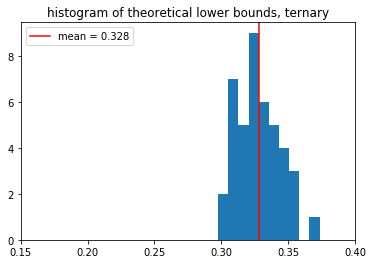

In [327]:
plt.title("histogram of theoretical lower bounds, ternary")
plt.hist(lbs_ternary)
plt.axvline(np.mean(lbs_ternary), color="red", label="mean = {}".format(np.round(np.mean(lbs_ternary), 3)))
plt.xlim(0.15,0.40)
plt.legend()
plt.show()

## For one player, 100 repetative experiment

Stephen Curry
p =  [0.15, 0.675, 0.175]
length =  440


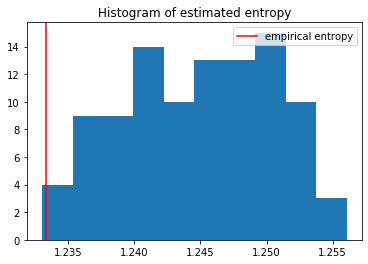

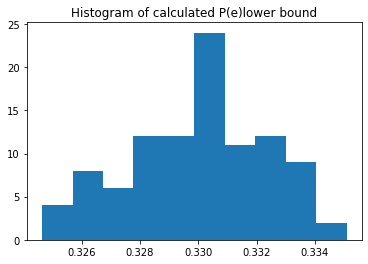

P(e) mean lower bound :  0.3299752873848877
P(e) upper bound :  0.32499999999999996
--------------------------



In [339]:
player_name = "Stephen Curry"

print(player_name)
player_data = stats_game[stats_game.Player == player_name][metric].reset_index(drop=True)
player_gamma = get_gamma(player_data, player_data, alpha, window)
size = len(player_gamma)
p0 = np.sum(np.array(player_gamma) == -1)/size
p1 = np.sum(np.array(player_gamma) == 0)/size
p2 = np.sum(np.array(player_gamma) == 1)/size
p = [p0, p1, p2]

# convert [-1, 0, 1] to [0, 1, 2]
player_gamma_uncomp = list(np.array(player_gamma) + 1)
player_gamma_string = list_to_string(player_gamma_uncomp)

print("p = ", p)
print("length = ", size)
compressed = compress(player_gamma_string)
compression_ratio = len(compressed)/len(player_gamma_string)

lb_list=[]
ent_list=[]
for i in range(100):
    ent = get_entropy_ternary(size, compression_ratio, show_graph=False)
    lb = inverse_binary_entropy_1(ent[0], a=0.001)
    lb_list.append(lb)
    ent_list.append(ent)
#     print("compression ratio: ", compression_ratio)
#     print("estimated entropy: ", ent[0])
#     print("P(e) lower bound : ", lb)

plt.title("Histogram of estimated entropy")
plt.hist(np.array(ent_list).flatten())
plt.axvline(entropy(p), color="red", label="empirical entropy")
plt.legend()
plt.show()

plt.title("Histogram of calculated P(e)lower bound")
plt.hist(lb_list)
plt.show()

print("P(e) mean lower bound : ", np.mean(lb_list))
print("P(e) upper bound : ", p0+p2)
print("--------------------------")
print()

# Prediction Error

## Ternary

In [222]:
# third party libraries
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
import numpy as np
import pandas as pd
import pickle

# personal libraries
from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.dataPrep.importData import *
import mrsc.src.utils as utils

# dennis libraries
from mrsc.src.dataPrep import gameData, annualData
from mrsc.src.predictions import cvxRegression, predictionMethods, SLA, gamePredictions, gameEvals

In [223]:
# players data
players = ['LeBron James', 'Kevin Durant', 'Stephen Curry', 'Russell Westbrook', 'James Harden', 
          'Giannis Antetokounmpo', 'Anthony Davis', 'Jimmy Butler', 'Draymond Green', 'Chris Paul',
          'Klay Thompson', 'John Wall', 'Paul George', 'DeMarcus Cousins', 'Rudy Gobert', 'Kyle Lowry',
          'Paul Millsap', 'Blake Griffin', 'Damian Lillard', 'DeAndre Jordan', 'Kyrie Irving',
          'Al Horford', 'DeMar DeRozan', 'Kevin Love', 'Andre Drummond', 'Carmelo Anthony', 'LaMarcus Aldridge',
          'Kemba Walker', 'Eric Bledsoe', 'Dwight Howard', 'Eric Gordon', 'George Hill', 'Jeff Teague', 
          'Andrew Wiggins', 'Serge Ibaka', 'Avery Bradley', 'Trevor Ariza', 'Devin Booker', 'Bradley Beal',
          'Karl-Anthony Towns', 'Marc Gasol', 'Khris Middleton']

In [ ]:
""" Parameters """
min_mp = 15

# read in data
df_games = gameData.createGameData()
#df_games = df_games[df_games.playMin >= min_mp]

# train/validation/test dates
trainDates = ('2012-09-01', '2016-06-01')
cvDates = ('2016-09-01', '2017-06-01')
testDates = ('2017-09-01', '2018-06-01')

# split data into train/cv/test
dfTrain, dfCV, dfTest = gameData.splitDFs(df_games, trainDates, cvDates, testDates)
dfTrainCV = pd.concat([dfTrain, dfCV])

# team data
teams = df_games.teamAbbr.unique()

# save
#gameData.saveTeamsDict(dfTrain, dfCV, dfTest, dfTrainCV, teams)
#gameData.saveTeamsPosDict(dfTrain, dfCV, dfTest, dfTrainCV, teams)

# load 
teamsPosTrainDict, teamsPosCVDict, teamsPosTestDict, teamsPosTrainCVDict = gameData.loadTeamsPosDict()
teamsTrainDict, teamsCVDict, teamsTestDict, teamsTrainCVDict = gameData.loadTeamsDict()
#teamsTrainCVDict = {team: pd.concat([teamsTrainDict[team], teamsCVDict[team]], axis=0) for team in list(teamsTrainDict.keys())}

In [229]:
player_delta_string

'1001100010010110000000110000100011000100100100101000110000100011011101101001111010100011010010001010001001100101000011011010001100010000110000111001100000010010001010010100001001110100000100001011010010110010000100110000001000010111000010100110110000110100010101000100101000100100010011010011011011100000100110000010100000100011000100101000010001000100111010001010001101001'

In [ ]:
def g(p):
    return entropy([p,1-p]) + p

In [250]:
g(0.33)

1.2449263727797275

In [269]:
entropy([1/6,2/3,1/6])

1.2516291673878228

In [270]:
entropy([1/3,1/3,1/3])

1.584962500721156

In [551]:
1/(2*math.pi*e)

0.05854983152431917

In [554]:
(e ** (2*1.6))

24.53253019710935